Import all the necessary libraries

In [ ]:
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import Image
from google.colab import files

Install the Kaggle package in the current environment

In [ ]:
!pip install -q kaggle

To verify that the Kaggle API is working properly and check whether the user has successfully authenticated with their credentials

In [ ]:
files.upload() # Upload kaggle.json file that was downloaded

!mkdir '/root/.kaggle'
!cp kaggle.json '/root/.kaggle'
!chmod 600 /root/.kaggle/kaggle.json # Sets the appropriate permissions for the kaggle.json file using the !chmod shell command

!kaggle datasets list # Displays the list of available datasets on Kaggle to check if everything is functioning properly

Saving kaggle.json to kaggle.json
ref                                                           title                                          size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  ---------------------------------------------  ----  -------------------  -------------  ---------  ---------------  
salvatorerastelli/spotify-and-youtube                         Spotify and Youtube                             9MB  2023-03-20 15:43:25           1071         38  1.0              
dgoenrique/netflix-movies-and-tv-shows                        Netflix Movies and TV Shows                     2MB  2023-03-13 18:49:00            766         25  1.0              
rajkumarpandey02/list-of-countries-by-gdp-sector-composition  List of Countries by GDP Sector Composition     8KB  2023-03-20 04:42:10            984         34  1.0              
datascientistanna/customers-dataset                           Shop

In [ ]:
res = input("Enter the desired resolution of the images: ") # Input the desired resolution of the images to be downloaded
!kaggle datasets download -d awsaf49/vinbigdata-{res}-image-dataset # Download the VinBigData Chest X-ray dataset in the desired resolution

Enter the desired resolution of the images: 512
100% 2.30G/2.30G [00:19<00:00, 196MB/s]
100% 2.30G/2.30G [00:19<00:00, 126MB/s]


In [ ]:
!unzip -q vinbigdata-{res}-image-dataset.zip # Unzip the VinBigData Chest X-ray dataset

Defining all the necessary functions

In [ ]:
"""
Function: Create_df
--------------------------------------------------------------------------------
Function to visualize the image with disease bounding boxes

Argument:
num_rows: Number of images to train the model

returns:
df_train: Dataframe of the images to be trained
"""
def Create_df(num_rows):
  df_train = pd.read_csv('/content/vinbigdata/train.csv', nrows = int(num_rows)) # Create a dataframe selecting only the first 'num_rows' images from the dataset

  # Convert the coordinates of the disease bounding boxes with respect to image original resolution to the image selected resolution
  df_train.loc[~df_train['x_min'].isna(), 'x_min'] = round(df_train.loc[~df_train['x_min'].isna(), 'x_min'] * (int(res) / df_train.loc[~df_train['x_min'].isna(), 'width'])).astype(int)
  df_train.loc[~df_train['x_max'].isna(), 'x_max'] = round(df_train.loc[~df_train['x_max'].isna(), 'x_max'] * (int(res) / df_train.loc[~df_train['x_max'].isna(), 'width'])).astype(int)
  df_train.loc[~df_train['y_min'].isna(), 'y_min'] = round(df_train.loc[~df_train['y_min'].isna(), 'y_min'] * (int(res) / df_train.loc[~df_train['y_min'].isna(), 'height'])).astype(int)
  df_train.loc[~df_train['y_max'].isna(), 'y_max'] = round(df_train.loc[~df_train['y_max'].isna(), 'y_max'] * (int(res) / df_train.loc[~df_train['y_max'].isna(), 'height'])).astype(int)

  df_train.loc[:, 'width'] = int(res) # Change all he values of 'width' column to selected width
  df_train.loc[:, 'height'] = int(res) # Change all the values of 'height' column to selected height

  return df_train # Displays the values of the modified dataframe

In [ ]:
"""
Function: Disease_Detection
--------------------------------------------------------------------------------
Function to visualize the image with disease bounding boxes

Arguments:
image_id: Name of the image file stored in the image_dir directory
df: Pandas DataFrame object containing annotations of the object bounding boxes

returns:
Image: Image of the X_ray with disease bounding boxes
"""
def Disease_Detection(image_id, df):
    image_path = image_dir + image_id + '.png' # Concatenates a image_dir (directory path) with image_id (file name) and .png (file extension)
    image = cv2.imread(image_path)
    dh, dw, _ = image.shape

    for index, row in df.iterrows():
        class_name = row['class_name']

        l = int(row['x_min']) # Read the values from 'x_min' column
        r = int(row['x_max']) # Read the values from 'x_max' column
        t = int(row['y_min']) # Read the values from 'y_min' column
        b = int(row['y_max']) # Read the values from 'y_max' column

        # Define text paramters
        color = (0, 0, 255)  # Red color
        thickness = 1 # Thickness of the text
        font_size = 0.75 # Text size

        cv2.putText(image, class_name, (l, t), cv2.FONT_HERSHEY_SIMPLEX, font_size, color, thickness) # Writes the text of the disease on the bounding boxes
        cv2.rectangle(image, (l, t), (r, b), (255,0,0), 2) # Draws the disease's rectangular bounding boxe

    plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='white', edgecolor='k') # Parameters of the image displayed
    return image

In [ ]:
"""
Function: InterOverUnion
--------------------------------------------------------------------------------
Function to find the value of intersection over union

Arguments:
BB_A: Coordinates of the prediction bounding box
BB_B: Coordinates of the original bounding box

returns:
IoU: Value of Intersection over union 
"""
def InterOverUnion(BB_A, BB_B):
	# Determine the x and y coordinates of the intersection of rectangular bounding box
	x_max_A = max(BB_A[0], BB_B[0])
	y_max_A = max(BB_A[1], BB_B[1])
	x_min_B = min(BB_A[2], BB_B[2])
	y_min_B = min(BB_A[3], BB_B[3])
	
  # Compute the intersection area of the rectangular bounding boxes
	Intersection_Area = max(0, x_min_B - x_max_A + 1) * max(0, y_min_B - y_max_A + 1)
	
  # Compute the area of both the prediction bounding box and the ground truth bounding box
	BB_A_Area = (BB_A[2] - BB_A[0] + 1) * (BB_A[3] - BB_A[1] + 1)
	BB_B_Area = (BB_B[2] - BB_B[0] + 1) * (BB_B[3] - BB_B[1] + 1)
	
	Inter_Union = Intersection_Area / float(BB_A_Area + BB_B_Area - Intersection_Area) # Compute the intersection over union
	
	return Inter_Union # returns the intersection over union value

In [ ]:
"""
Function: Avg_Coordinates
--------------------------------------------------------------------------------
Function to visualize the image with disease bounding boxes

Arguments:
df: Dataframe containing bounding box coordinates for disease detected in images
threshold: Floating-point value representing the IoU threshold to determine if two bounding boxes belong to the same diseases

returns:
df_new: New dataframe with the averaged bounding box coordinates for diseases detected in the input dataframe
"""
def Avg_Coordinates(df, threshold):
  df_temp = df.reset_index()
  # Empty duplicate dictionary to store pairs of bounding boxes that have an IoU greater than the set threshold
  dup = {} 
  for ind_1, r_1 in df_temp.iterrows():
      if ind_1 < len(df_temp) - 1:
          next_ind = ind_1 + 1
          for index2, r_2 in df_temp.loc[next_ind:,:].iterrows():
              if r_1["class_id"] == r_2["class_id"]:
                  BB_A = [r_1['x_min'], r_1['y_min'], r_1['x_max'], r_1['y_max']]
                  BB_B = [r_2['x_min'], r_2['y_min'], r_2['x_max'], r_2['y_max']]
                  iou = InterOverUnion(BB_A, BB_B)
                  if iou > threshold: # IoU is greater than the set threshold, stores in the duplicate dictionary
                      if r_1["index"] not in dup:
                          dup[r_1["index"]] = []
                      dup[r_1["index"]].append(r_2["index"])

  key_rm = []
  for k in dup:
      for i in dup[k]:
          if i in dup:
              for id in dup[i]:
                  if id not in dup[k]:
                      dup[k].append(id)
              if i not in key_rm:
                  key_rm.append(i)
  # Remove any duplicate entries in the duplicate dictionary and consolidate all the indices belonging to the same disease into a single list
  for i in key_rm:
    del dup[i]

  rows = []
  ind_rm = []
  for k in dup:
    row = df_temp[df_temp['index'] == k].iloc[0]
    X_min = [row['x_min']]
    X_max = [row['x_max']]
    Y_min = [row['y_min']]
    Y_max = [row['y_max']]
    ind_rm.append(k)
    for i in dup[k]:
        ind_rm.append(i)
        row = df_temp[df_temp['index'] == i].iloc[0]
        X_min.append(row['x_min'])
        X_max.append(row['x_max'])
        Y_min.append(row['y_min'])
        Y_max.append(row['y_max'])
    Avg_X_min = sum(X_min) / len(X_min)
    Avg_X_max = sum(X_max) / len(X_max)
    Avg_Y_min = sum(Y_min) / len(Y_min)
    Avg_Y_max = sum(Y_max) / len(Y_max)
    new_row = [row['image_id'], row['class_name'], row['class_id'], Avg_X_min, Avg_Y_min, X_max_avg, Avg_Y_max, row['width'], row['height']]
    rows.append(new_row)

  for index, row in df_temp.iterrows():
    if row['index'] not in ind_rm:
      new_row = [row['image_id'], row['class_name'], row['class_id'], row['x_min'], row['y_min'], row['x_max'], row['y_max'], row['width'], row['height']]
      rows.append(new_row)

  df_new = pd.DataFrame(rows, columns =['image_id', 'class_name', 'class_id', 'x_min', 'y_min', 'x_max', 'y_max', 'width', 'height'])
  return df_new # returns new dataframe

In [ ]:
"""
Function: Images_Text
--------------------------------------------------------------------------------
Function generates a text file containing the file paths of the corresponding images and saves it to the specified filepath

Arguments:
images_list: List of image IDs
filepath: Path of the output file

returns:
None
"""
def Images_Text(images_list, filepath):
    images_dir = '/content/vinbigdata/train/'
    rows = []
    for image_id in images_list:
        rows.append(image_dir + image_id + '.png')
    f = open(filepath, "w")
    f.write("\n".join(rows))
    f.close()

In [ ]:
num_rows = input("Please enter the number of images to train the model: ")
df_train = Create_df(num_rows) # Call the Create_df function
df_train # Display the df_train dataframe

Please enter the number of images to train the model: 5000


image_id          class_name  class_id rad_id  \
0     50a418190bc3fb1ef1633bf9678929b3          No finding        14    R11   
1     21a10246a5ec7af151081d0cd6d65dc9          No finding        14     R7   
2     9a5094b2563a1ef3ff50dc5c7ff71345        Cardiomegaly         3    R10   
3     051132a778e61a86eb147c7c6f564dfe  Aortic enlargement         0    R10   
4     063319de25ce7edb9b1c6b8881290140          No finding        14    R10   
...                                ...                 ...       ...    ...   
4995  7526f748d877b8bb9fa062f8dbedc28d          No finding        14     R5   
4996  0e6af94d17007c94d858b3bb7adb7dac        Infiltration         6     R8   
4997  33f92103ce3d750ff87cb6aae3154d40          No finding        14    R15   
4998  38d665e8c7e8cc518e6a640da3bd7147          No finding        14     R8   
4999  d56ea789585115ee47580ed320a8532e        Cardiomegaly         3     R9   

      x_min  y_min  x_max  y_max  width  height  
0       NaN    NaN    NaN    NaN    512     512  
1       NaN    NaN    NaN    NaN    512     512  
2     170.0  301.0  407.0  401.0    512     512  
3     281.0  132.0  358.0  181.0    512     512  
4       NaN    NaN    NaN    NaN    512     512  
...     ...    ...    ...    ...    ...     ...  
4995    NaN    NaN    NaN    NaN    512     512  
4996  361.0  202.0  463.0  393.0    512     512  
4997    NaN    NaN    NaN    NaN    512     512  
4998    NaN    NaN    NaN    NaN    512     512  
4999  226.0  238.0  398.0  289.0    512     512  

[5000 rows x 10 columns]

In [ ]:
test_image_id = '4b56bc6d22b192f075f13231419dfcc8'
df_test = df_train[df_train['image_id'] == test_image_id]
df_test # Display the dataframe with the assigned image_id

image_id          class_name  class_id rad_id  \
139   4b56bc6d22b192f075f13231419dfcc8  Pleural thickening        11     R8   
3353  4b56bc6d22b192f075f13231419dfcc8  Pleural thickening        11     R9   

      x_min  y_min  x_max  y_max  width  height  
139   449.0  287.0  479.0  326.0    512     512  
3353   51.0  299.0   77.0  344.0    512     512

In [ ]:
image_dir = '/content/vinbigdata/train/' # Path of the train image directory is stored in a variable

labels = [
    "Aortic enlargement",
    "Atelectasis",
    "Calcification",
    "Cardiomegaly",
    "Consolidation",
    "ILD",
    "Infiltration",
    "Lung Opacity",
    "Nodule/Mass",
    "Other lesion",
    "Pleural effusion",
    "Pleural thickening",
    "Pneumothorax",
    "Pulmonary fibrosis"
] # label for all the diseases

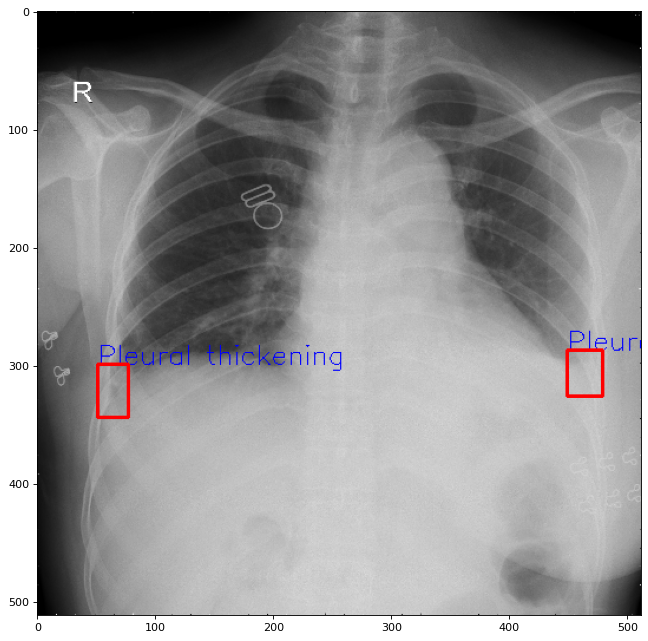

In [ ]:
image = Disease_Detection(test_image_id, df_test) # Call the Disease_Detection function
plt.imshow(image)
plt.show() # Displays the image

In [ ]:
images_list = df_train.groupby('image_id').apply(list).reset_index()['image_id'].tolist()
image_dir = '/content/vinbigdata/train/' # Assign the path of the train image directory

Box = []
# Creates text file containing coordinates of the diseases in the corresponding image in the YOLOv5 format
for image_id in images_list:
  df_sub = df_train[df_train['image_id'] == image_id].reset_index()
  df_sub = Avg_Coordinates(df_sub,  0.5)
  Box.append(df_sub)
  new_row = []
  if int(df_sub["class_id"][0]) == 14:
      new_row.append("14 0.5 0.5 1.0 1.0")
  else:
      for index, row in df_sub.iterrows():
          width = int(row["width"])
          height = int(row["height"])
          c_x = (int(row["x_min"]) + int(row["x_max"])) / 2 / width
          c_y = (int(row["y_min"]) + int(row["y_max"])) / 2 / height
          b_w = (int(row["x_max"]) - int(row["x_min"])) / width
          b_h = (int(row["y_max"]) - int(row["y_min"])) / height
          row = [str(row["class_id"]), str(c_x), str(c_y), str(b_w), str(b_h)]
          new_row.append(" ".join(row))
      new_row.append("15 0.5 0.5 1.0 1.0")
  f = open(image_dir + image_id + ".txt", "w")
  f.write("\n".join(new_row))
  f.close()

df_new = pd.concat(Box) # Create a new dataframe for the train images
df_new.to_csv('/content/vinbigdata/new_train.csv', index=False)

In [ ]:
df_train = pd.read_csv('/content/vinbigdata/new_train.csv')
# Split the dataset df_train into two separate subsets: a training set (train) and a validation set (validation)
train, validation = train_test_split(df_train, test_size=0.2) # Split ratio is set to 80% for the training set and 20% for the validation

train_images_list = train.groupby('image_id').apply(list).reset_index()['image_id'].tolist()
validation_images_list = validation.groupby('image_id').apply(list).reset_index()['image_id'].tolist()

train_path = '/content/train.txt'
validation_path = '/content/val.txt'
Images_Text(train_images_list, train_path)
Images_Text(validation_images_list, validation_path)

In [ ]:
!rm -f /content/config.yaml
!echo "train: /content/train.txt" >> /content/config.yaml
!echo "val: /content/val.txt" >> /content/config.yaml
!echo "nc: 16" >> /content/config.yaml
!echo "names: ['Aortic enlargement','Atelectasis','Calcification','Cardiomegaly','Consolidation','ILD','Infiltration','Lung Opacity','Nodule/Mass','Other lesion','Pleural effusion','Pleural thickening','Pneumothorax','Pulmonary fibrosis','No finding','Finding']" >> /content/config.yaml

Train the YOLOv5 model (Image Size: 512, Batch Size: 16, Epochs: 100)

In [ ]:
%cd /content
!git clone https://github.com/ultralytics/yolov5.git

%cd /content/yolov5/
!pip install -r requirements.txt

!python train.py --img-size 512 --batch-size 16 --epochs 100 --data /content/config.yaml --weights yolov5s.pt --cache

/content
Cloning into 'yolov5'...
remote: Enumerating objects: 15338, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 15338 (delta 0), reused 2 (delta 0), pack-reused 15335
Receiving objects: 100% (15338/15338), 14.21 MiB | 31.84 MiB/s, done.
Resolving deltas: 100% (10523/10523), done.
/content/yolov5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.5 MB/s eta 0:00:00
train: weights=yolov5s.pt, cfg=, data=/content/config.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=run

Test the YOLOv5 model (Confidence Threshold: 0.4)

In [ ]:
%cd /content/yolov5
!python detect.py --weights /content/yolov5/runs/train/exp/weights/best.pt --img 512 --conf 0.4 --source /content/val.txt --save-txt --save-conf --exist-ok

/content/yolov5
detect: weights=['/content/yolov5/runs/train/exp/weights/best.pt'], source=/content/val.txt, data=data/coco128.yaml, imgsz=[512, 512], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-128-gb96f35c Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7053277 parameters, 0 gradients, 15.9 GFLOPs
image 1/942 /content/vinbigdata/train/001d127bad87592efe45a5c7678f8b8d.png: 512x512 1 Pulmonary fibrosis, 1 Finding, 9.0ms
image 2/942 /content/vinbigdata/train/00948e3e6acc03044af454fb9700ca60.png: 512x512 1 No finding, 9.0ms
image 3/942 /content/vinbigdata/train/00e25f831ccd21bd41b558cfccbf1be7.png: 512x512 1 No findi

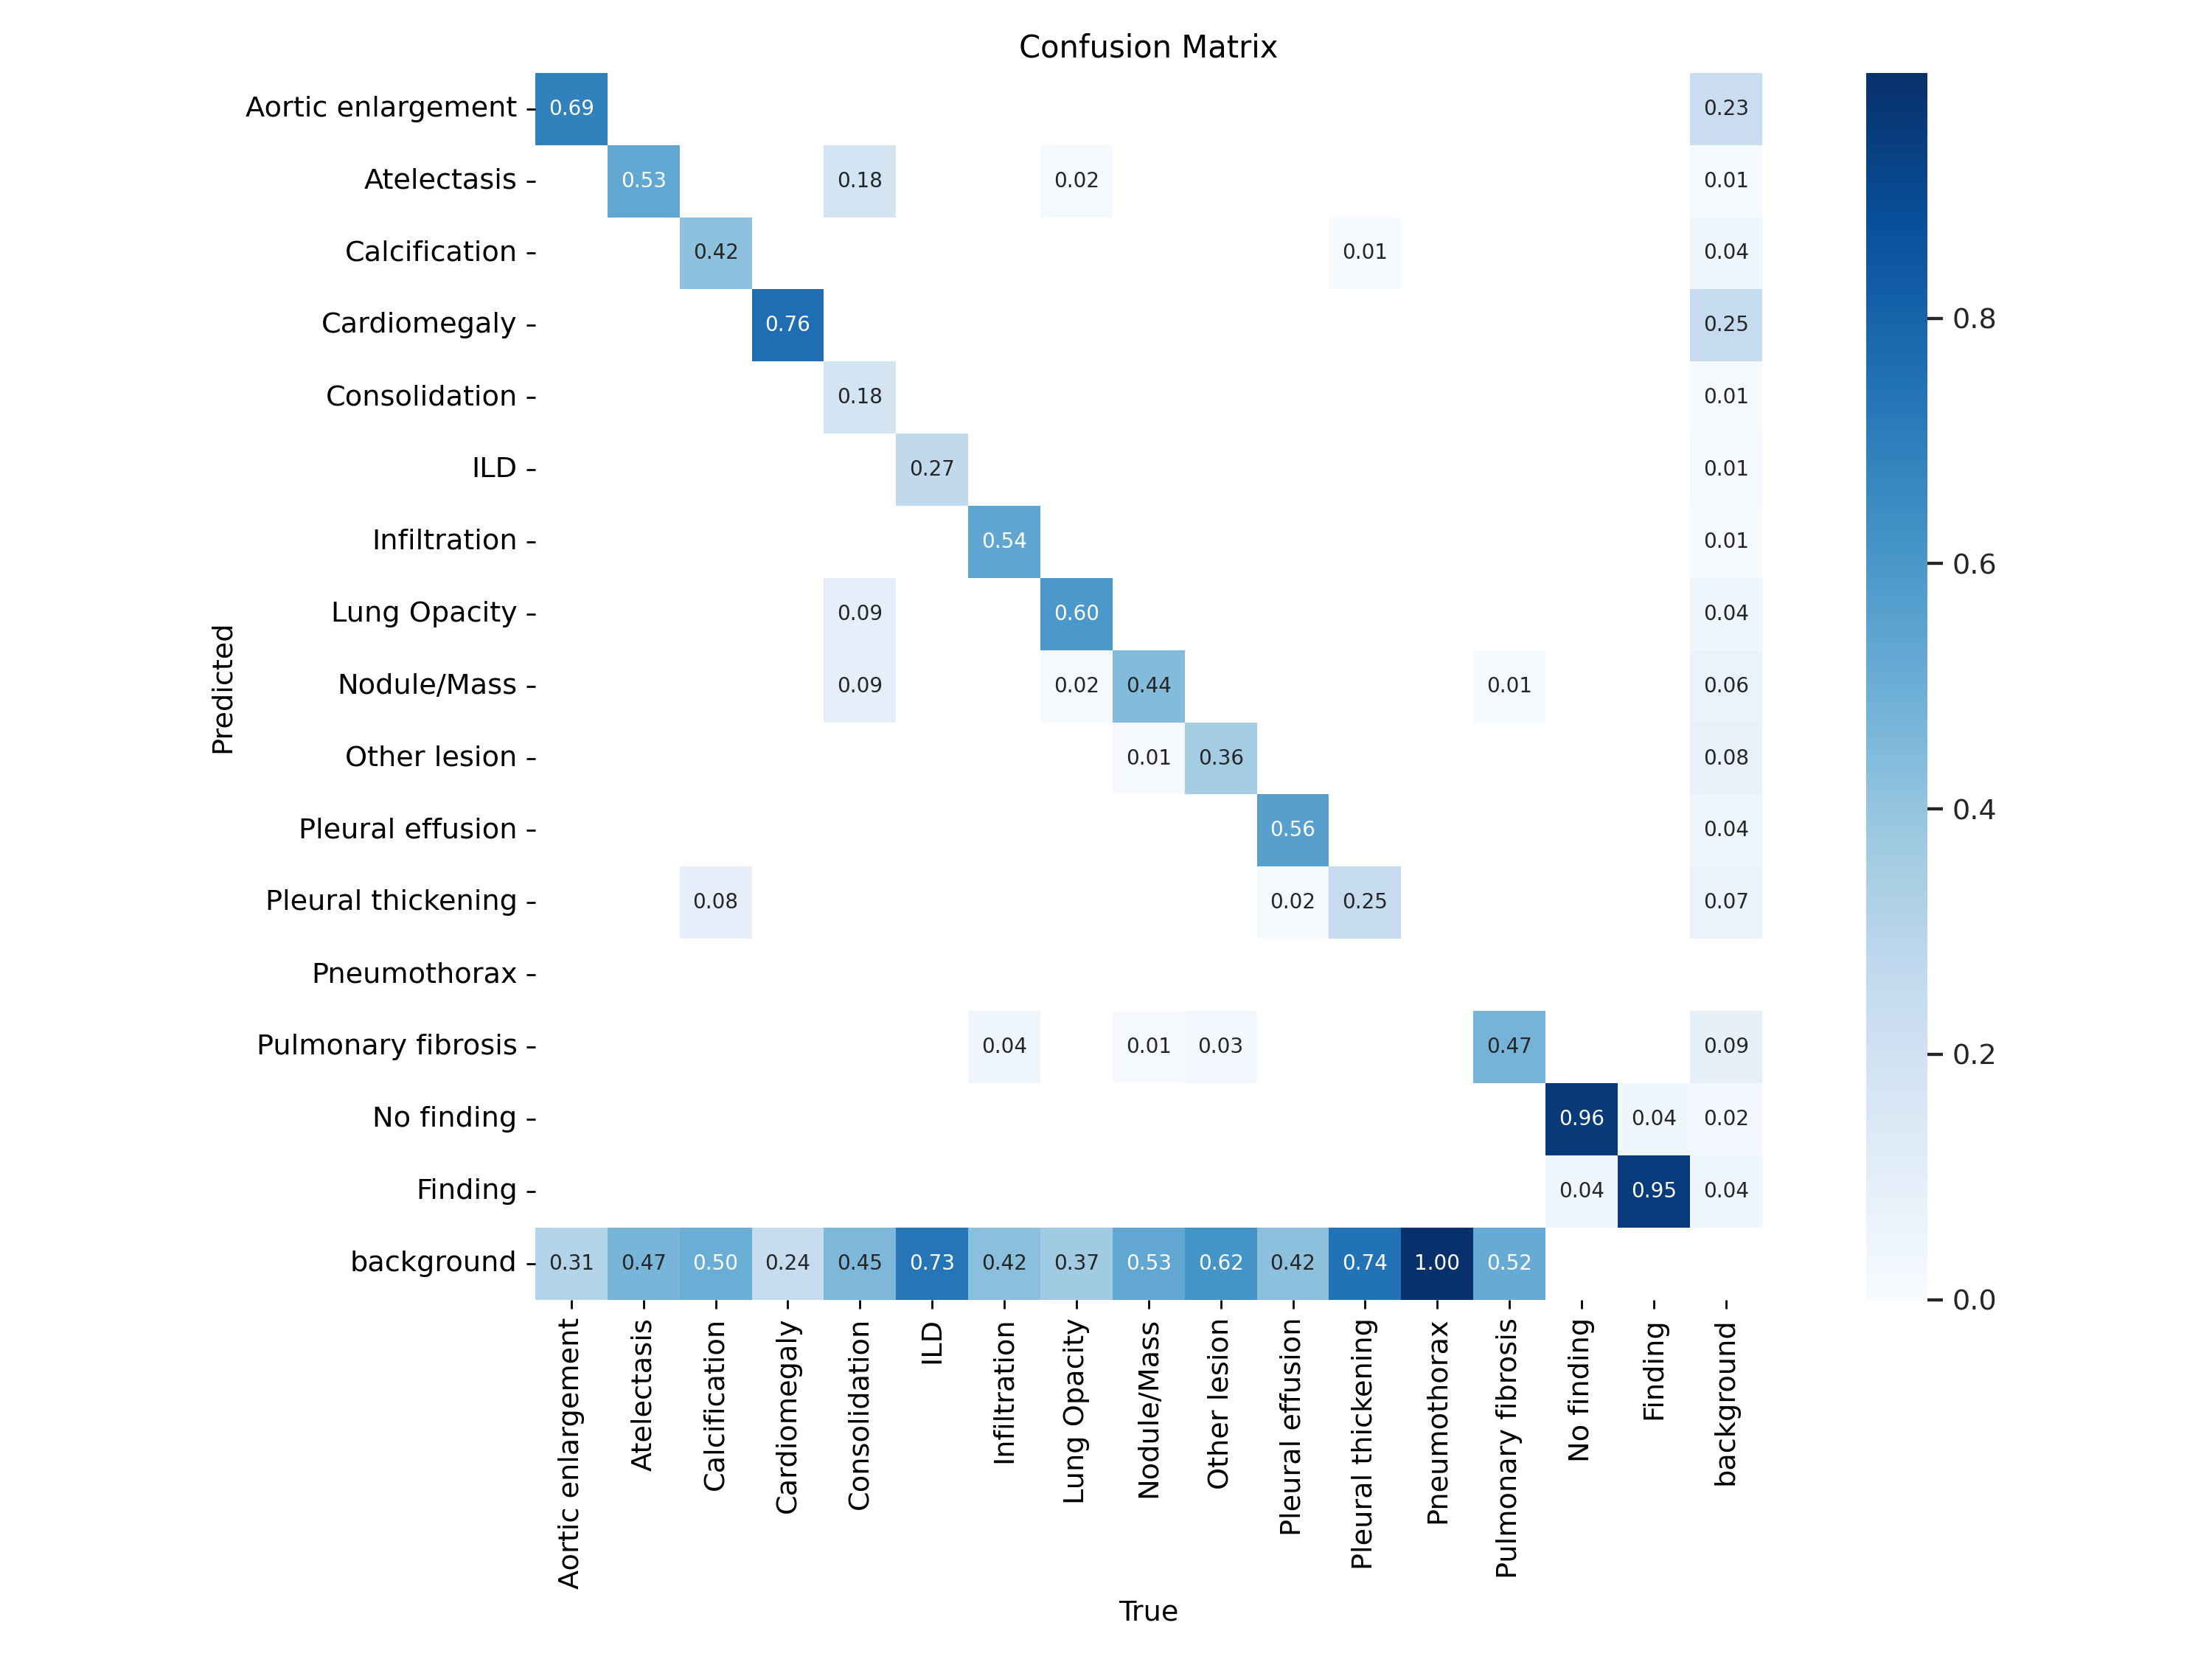

In [ ]:
Image('/content/yolov5/runs/train/exp/confusion_matrix.png', width=800) # Display Confusion Matrix

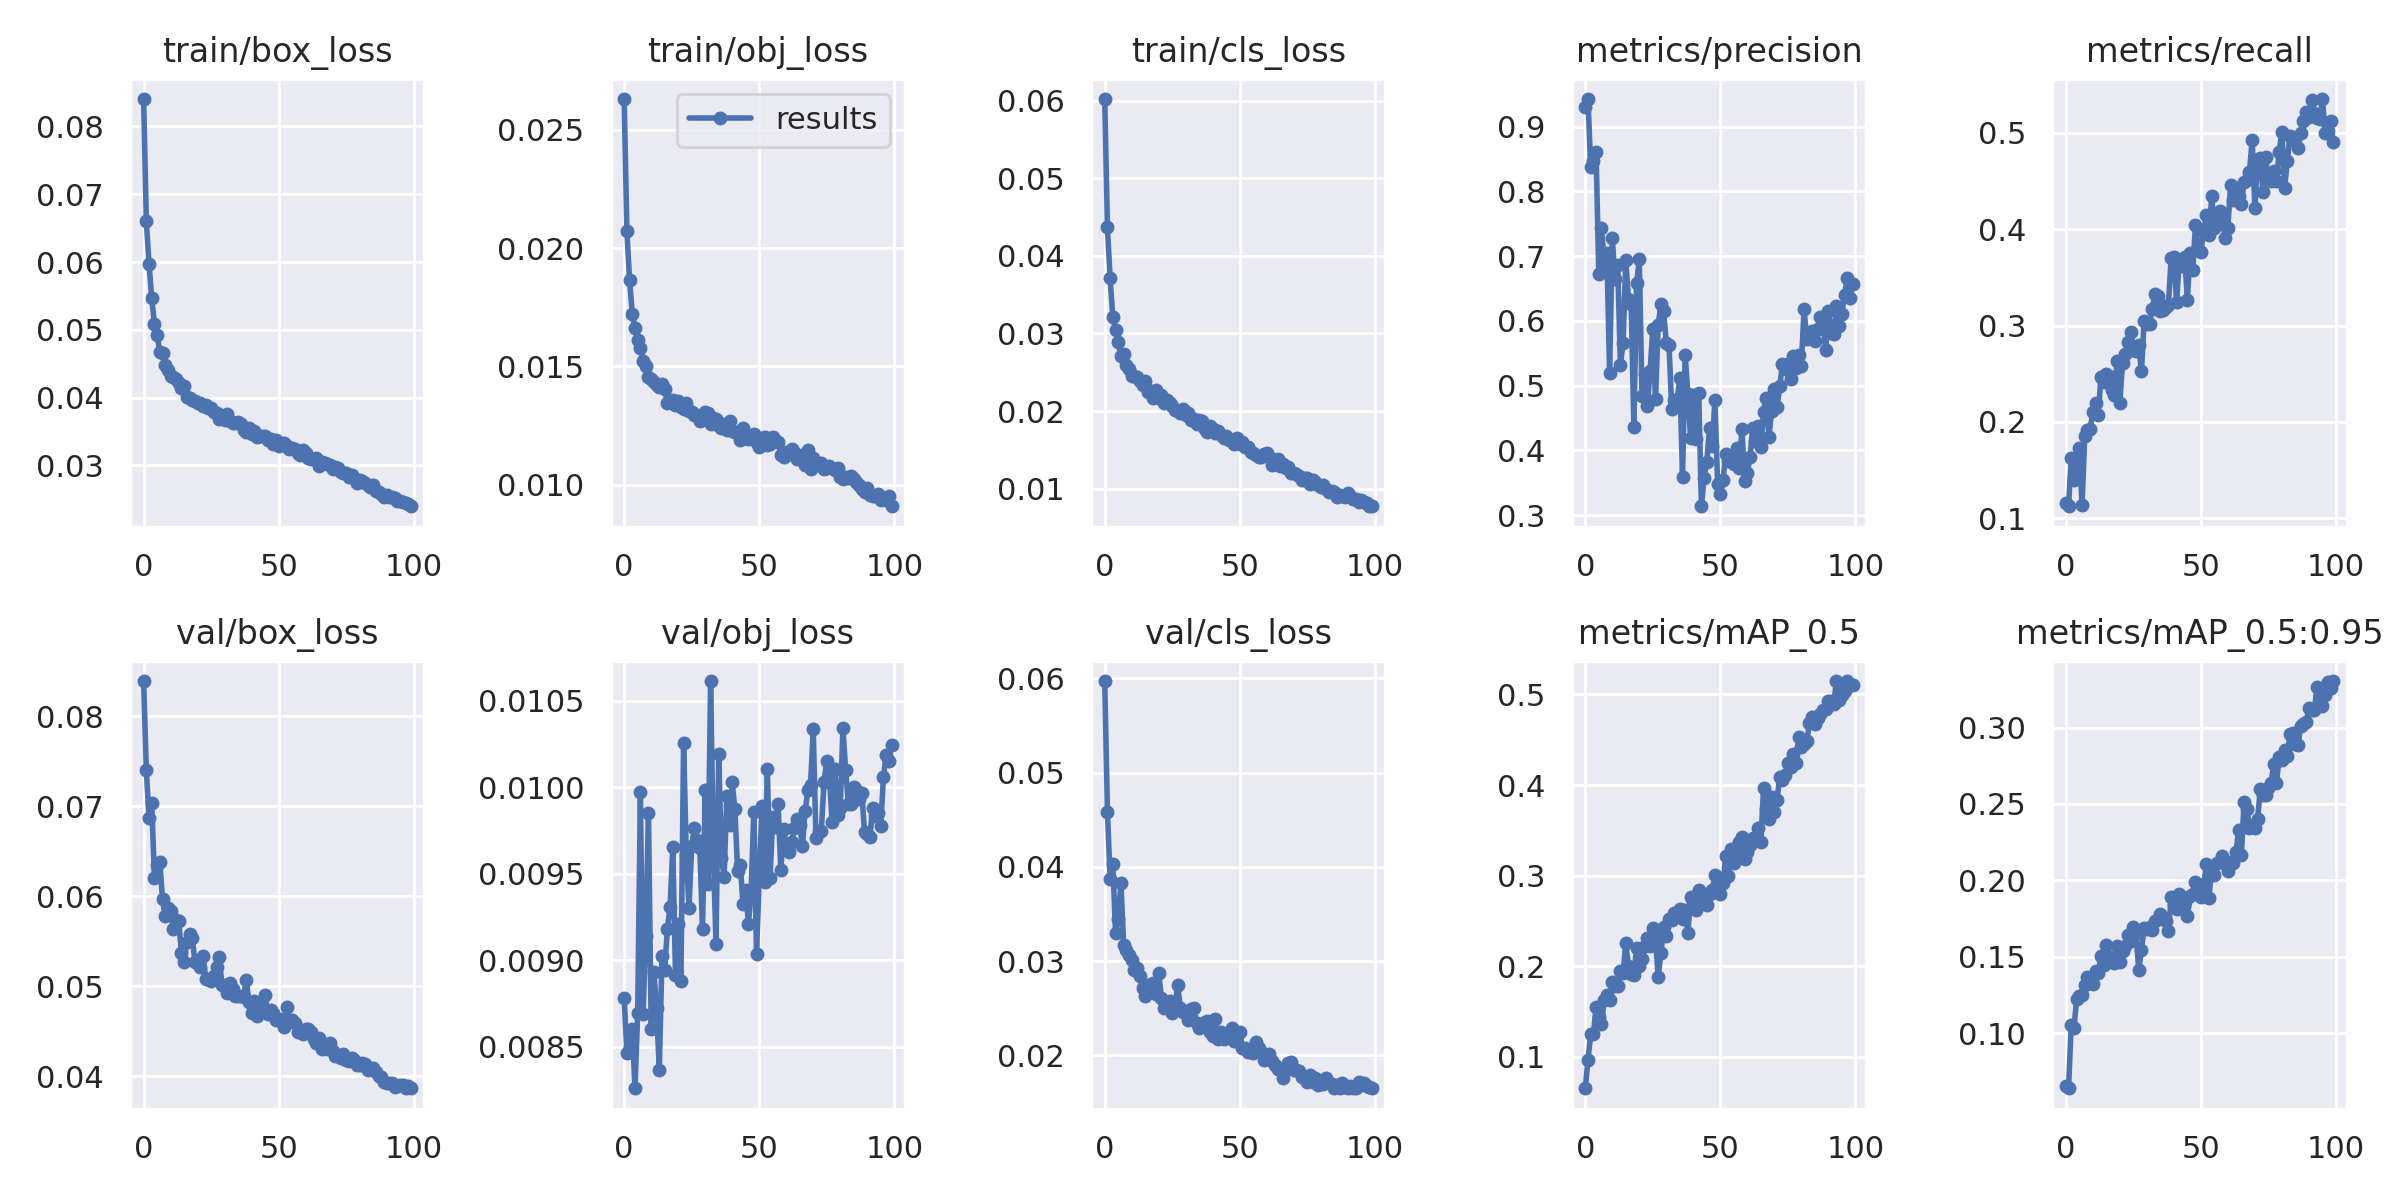

In [ ]:
Image('/content/yolov5/runs/train/exp/results.png', width=800) # Display Results

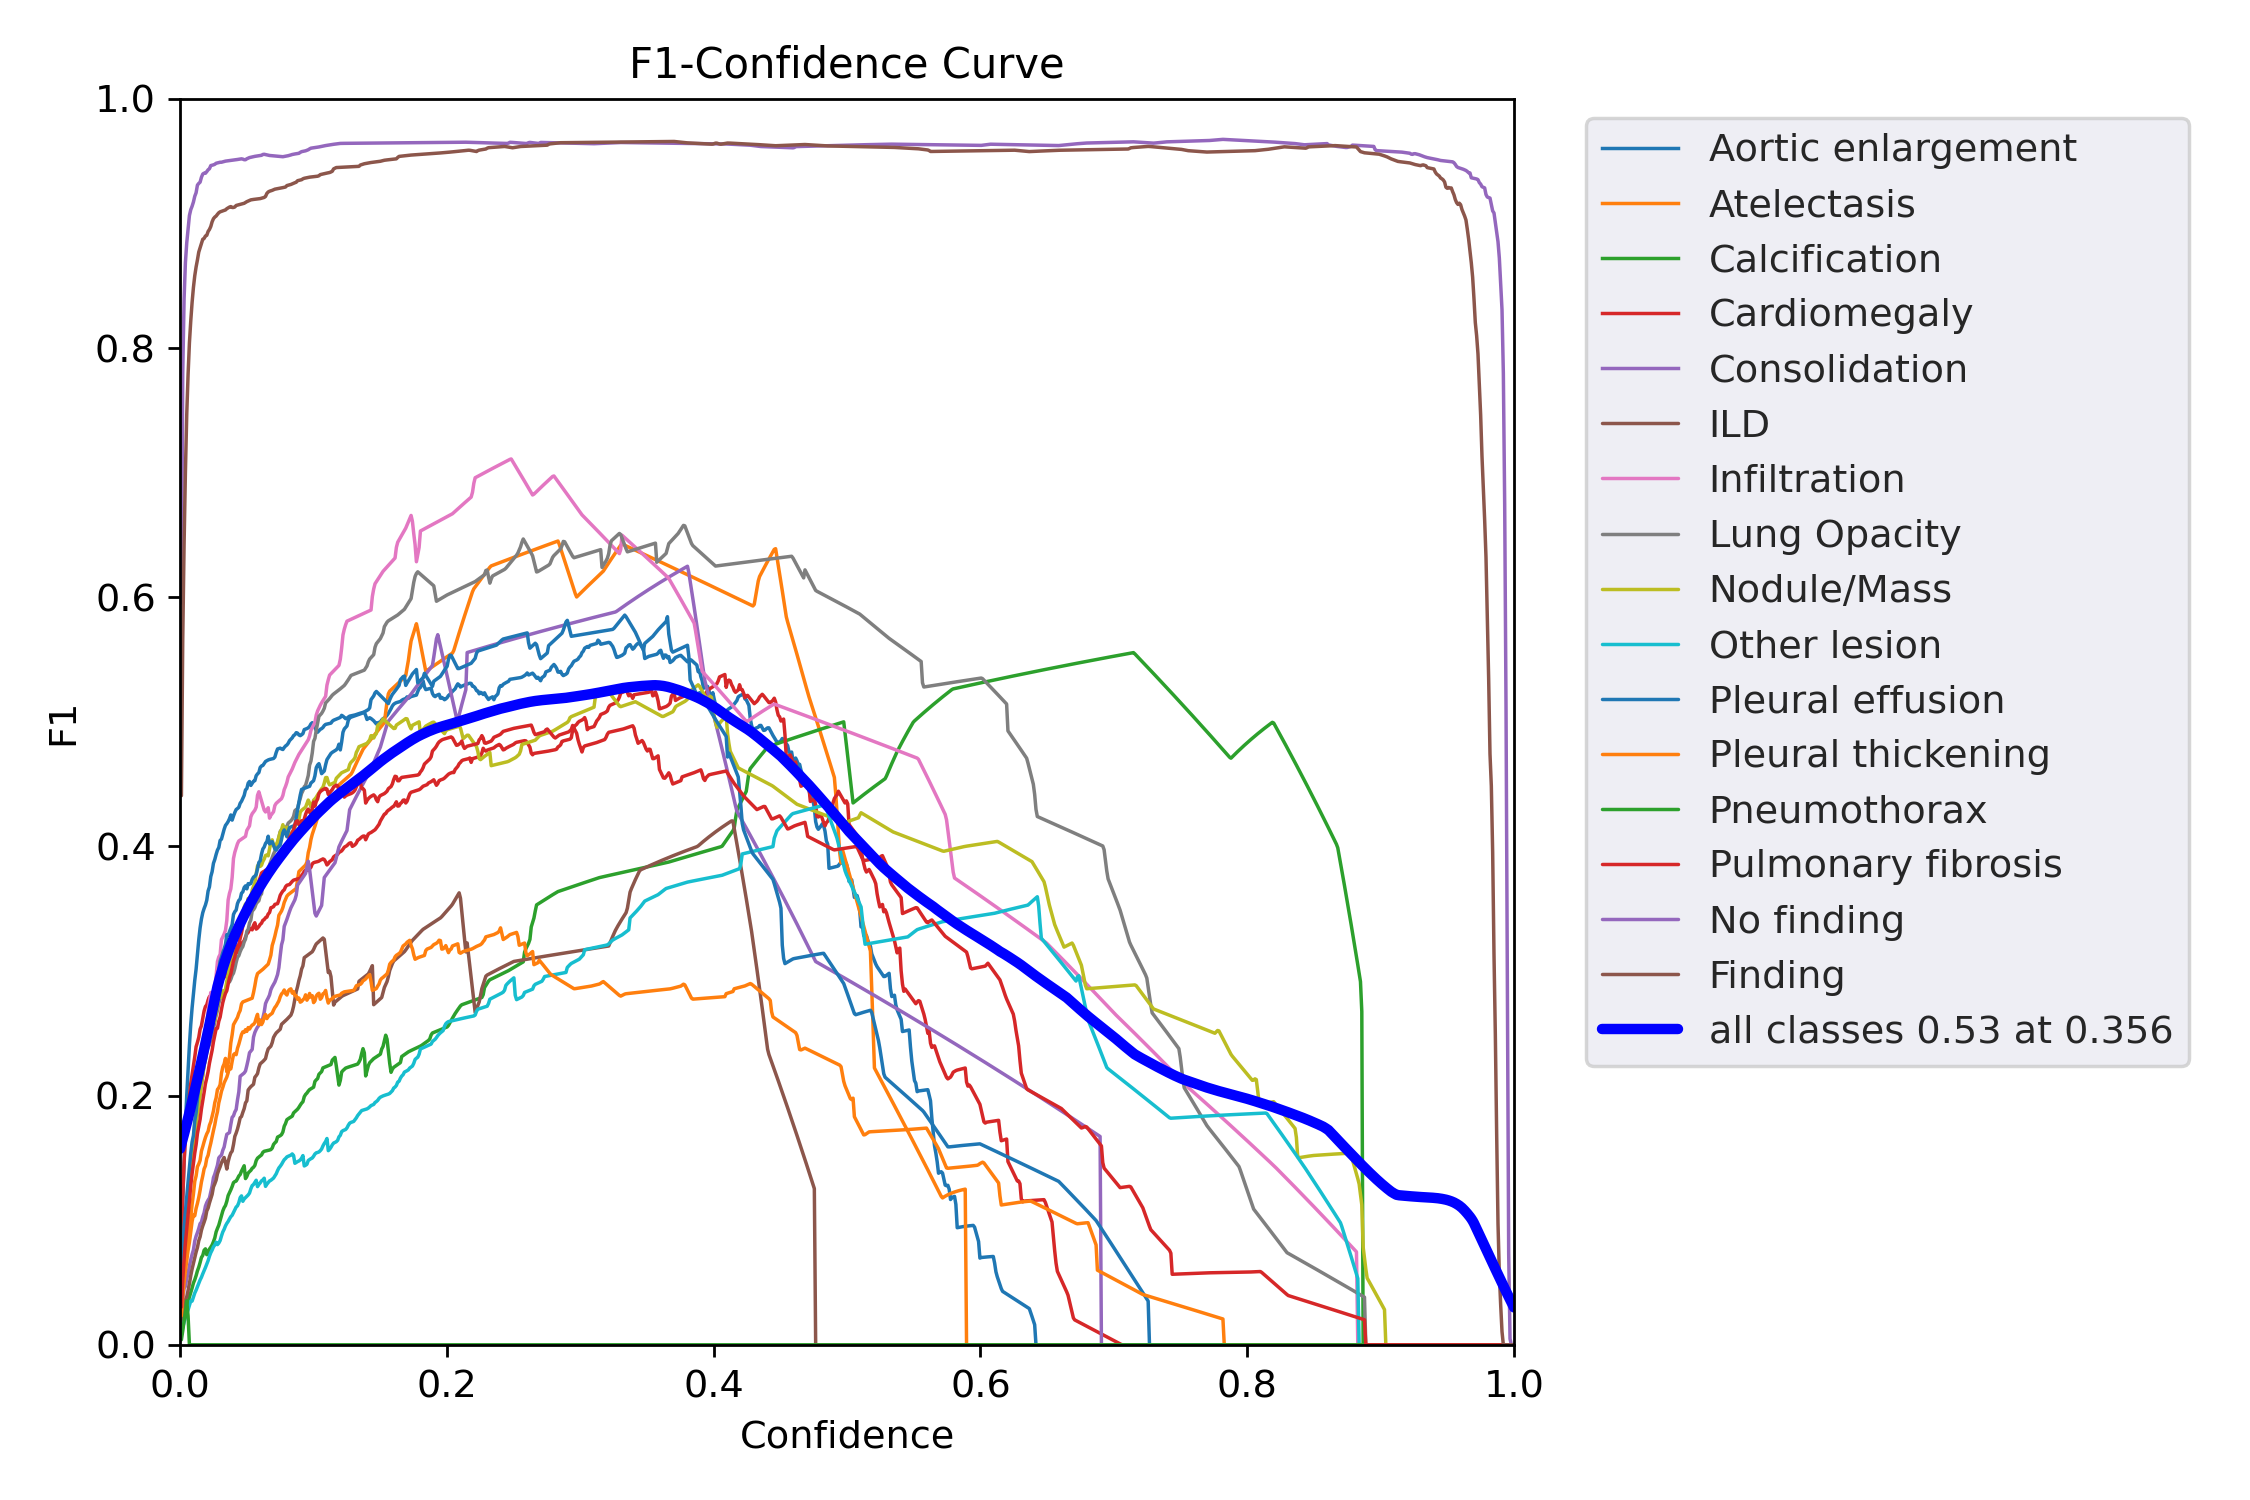

In [ ]:
Image('/content/yolov5/runs/train/exp/F1_curve.png', width=800) # Display F1 Curve

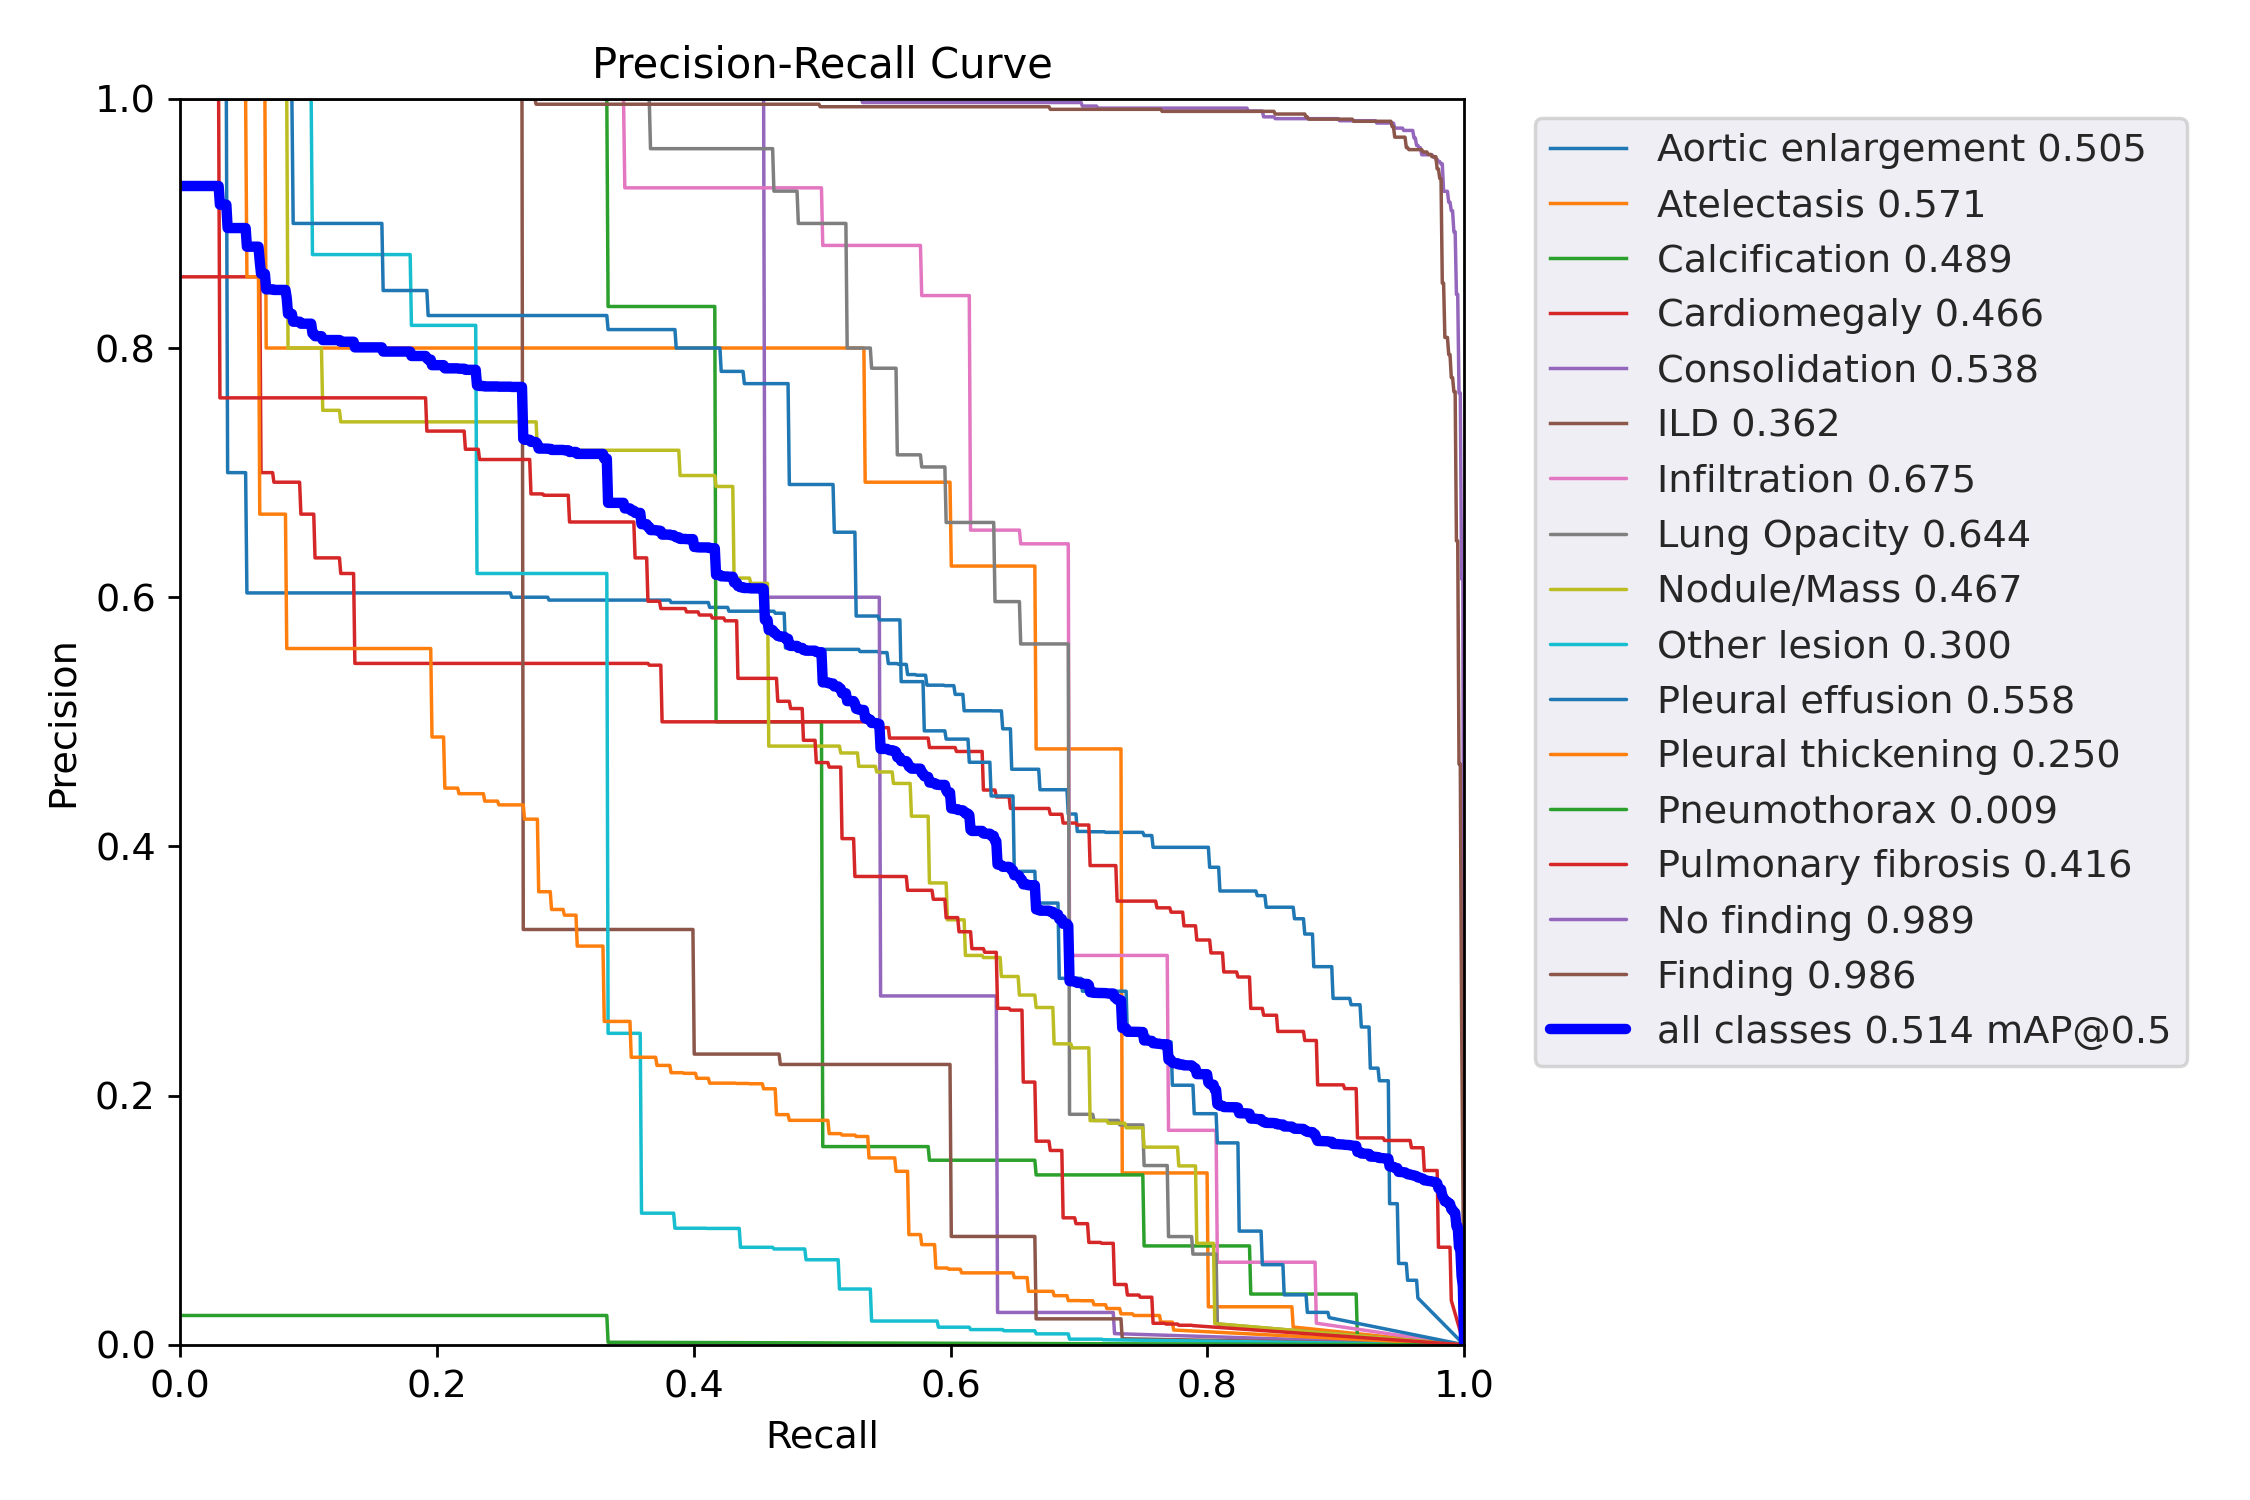

In [ ]:
Image('/content/yolov5/runs/train/exp/PR_curve.png', width=800) # Display PR Curve

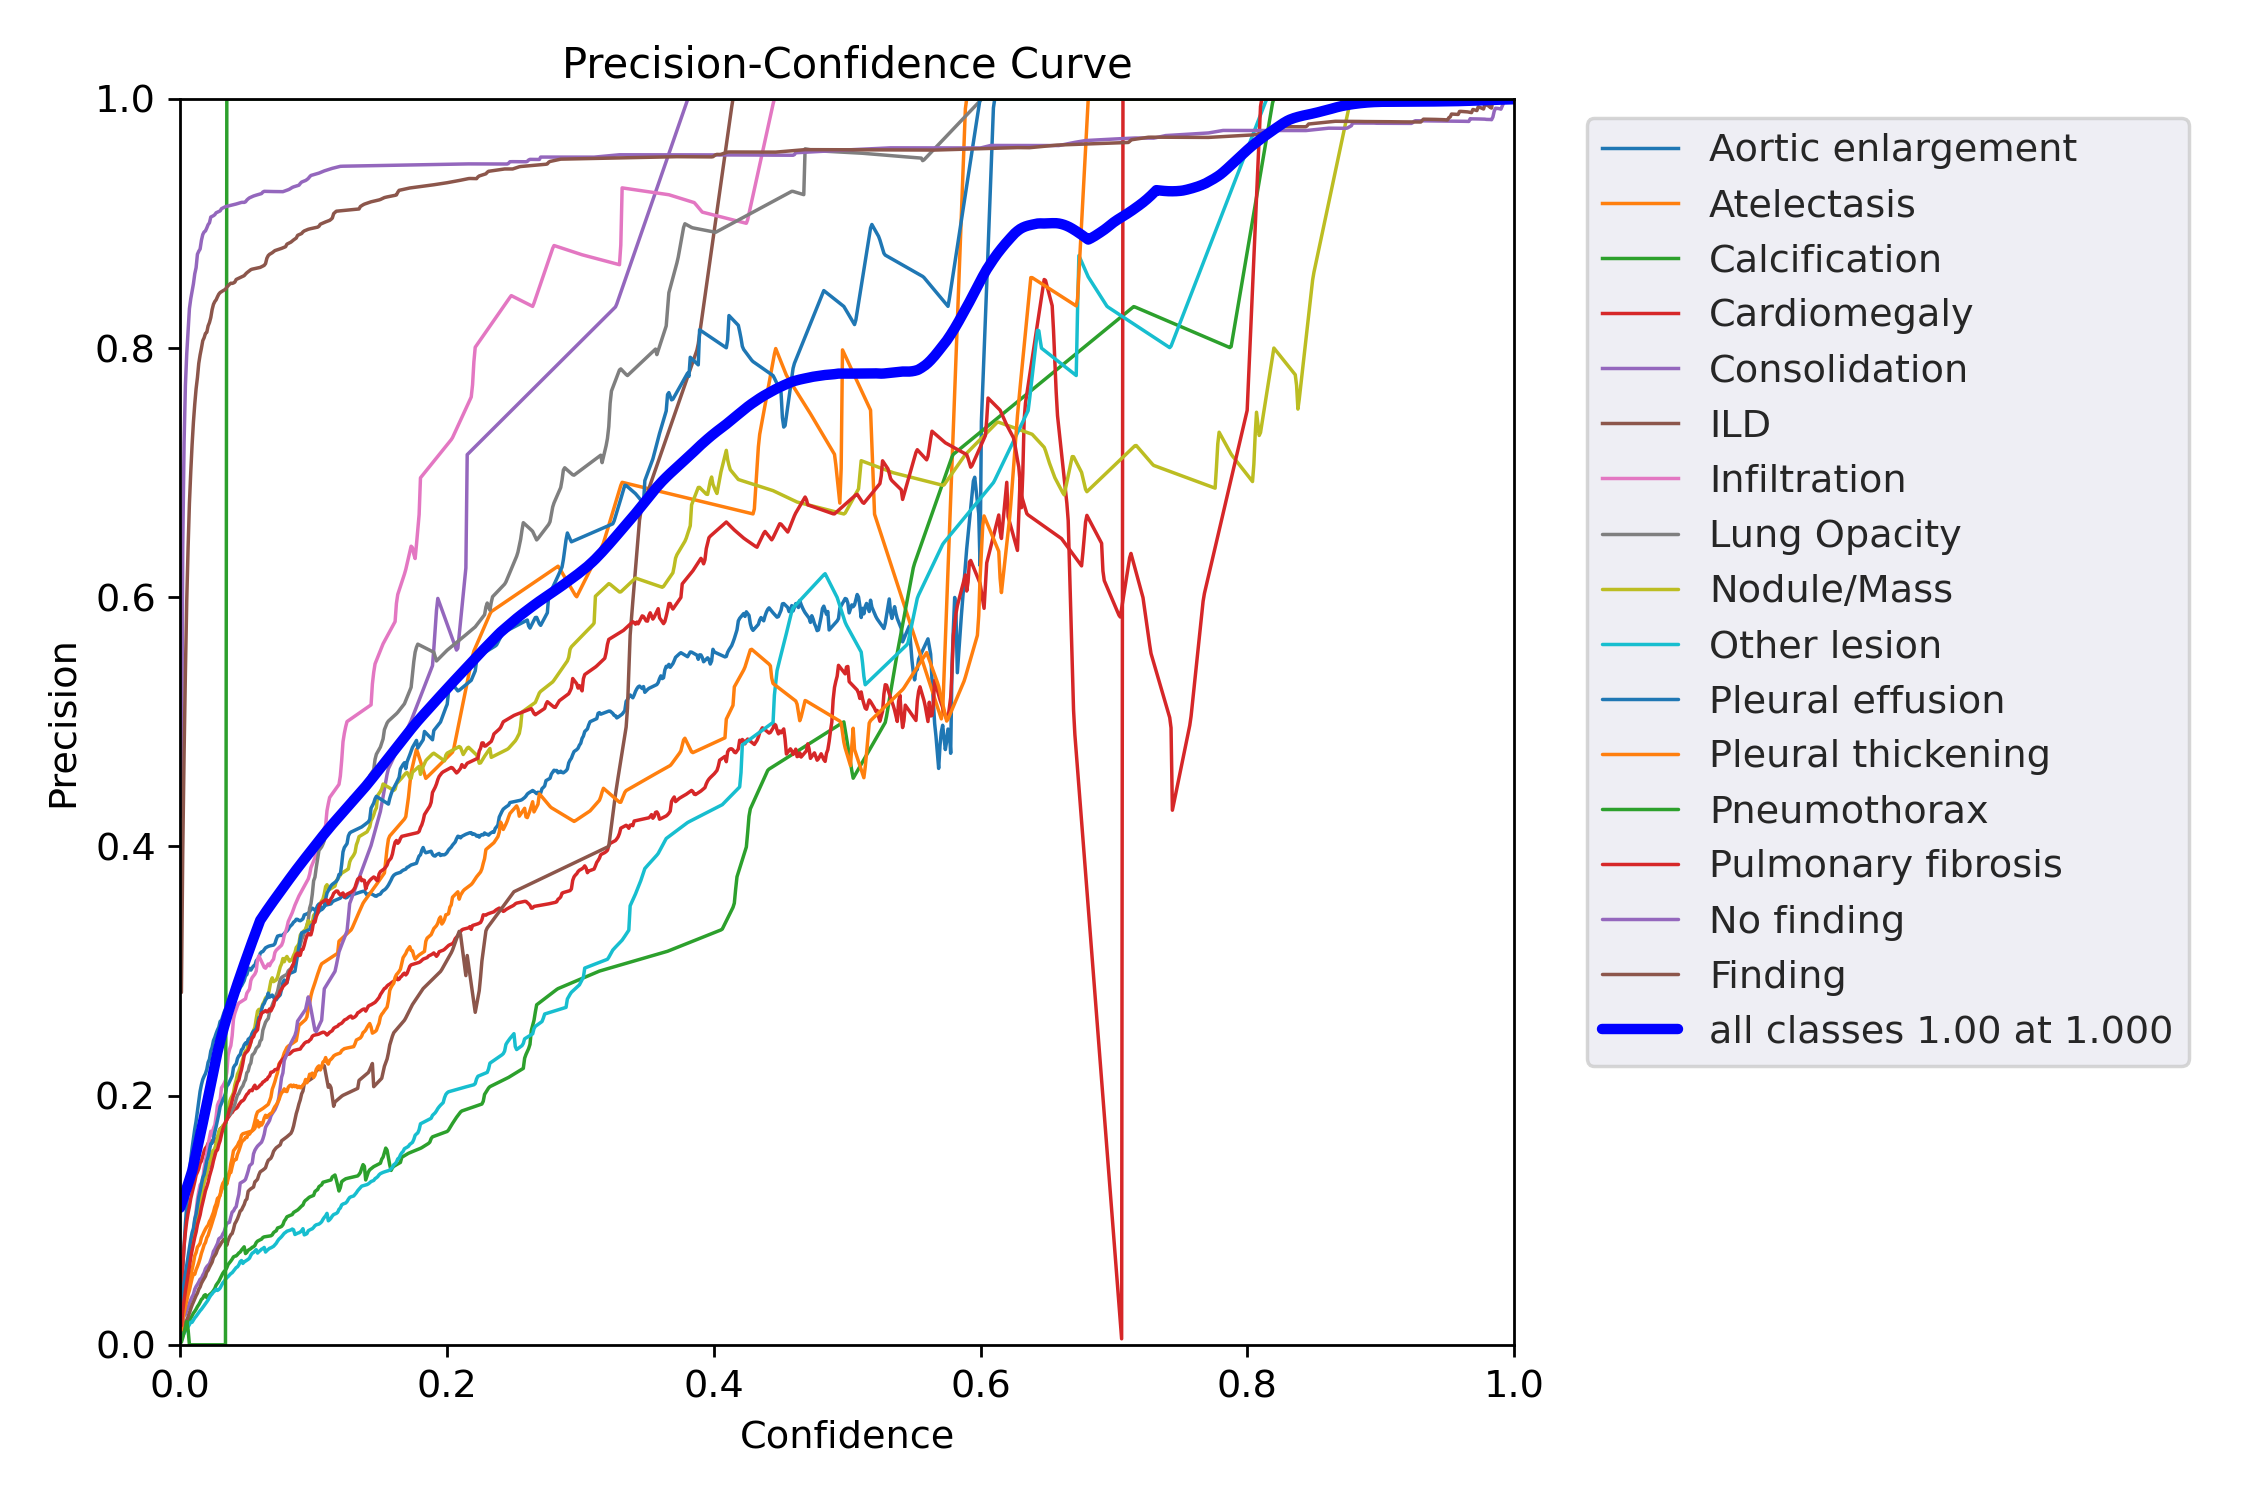

In [ ]:
Image('/content/yolov5/runs/train/exp/P_curve.png', width=800) # Display P Curve

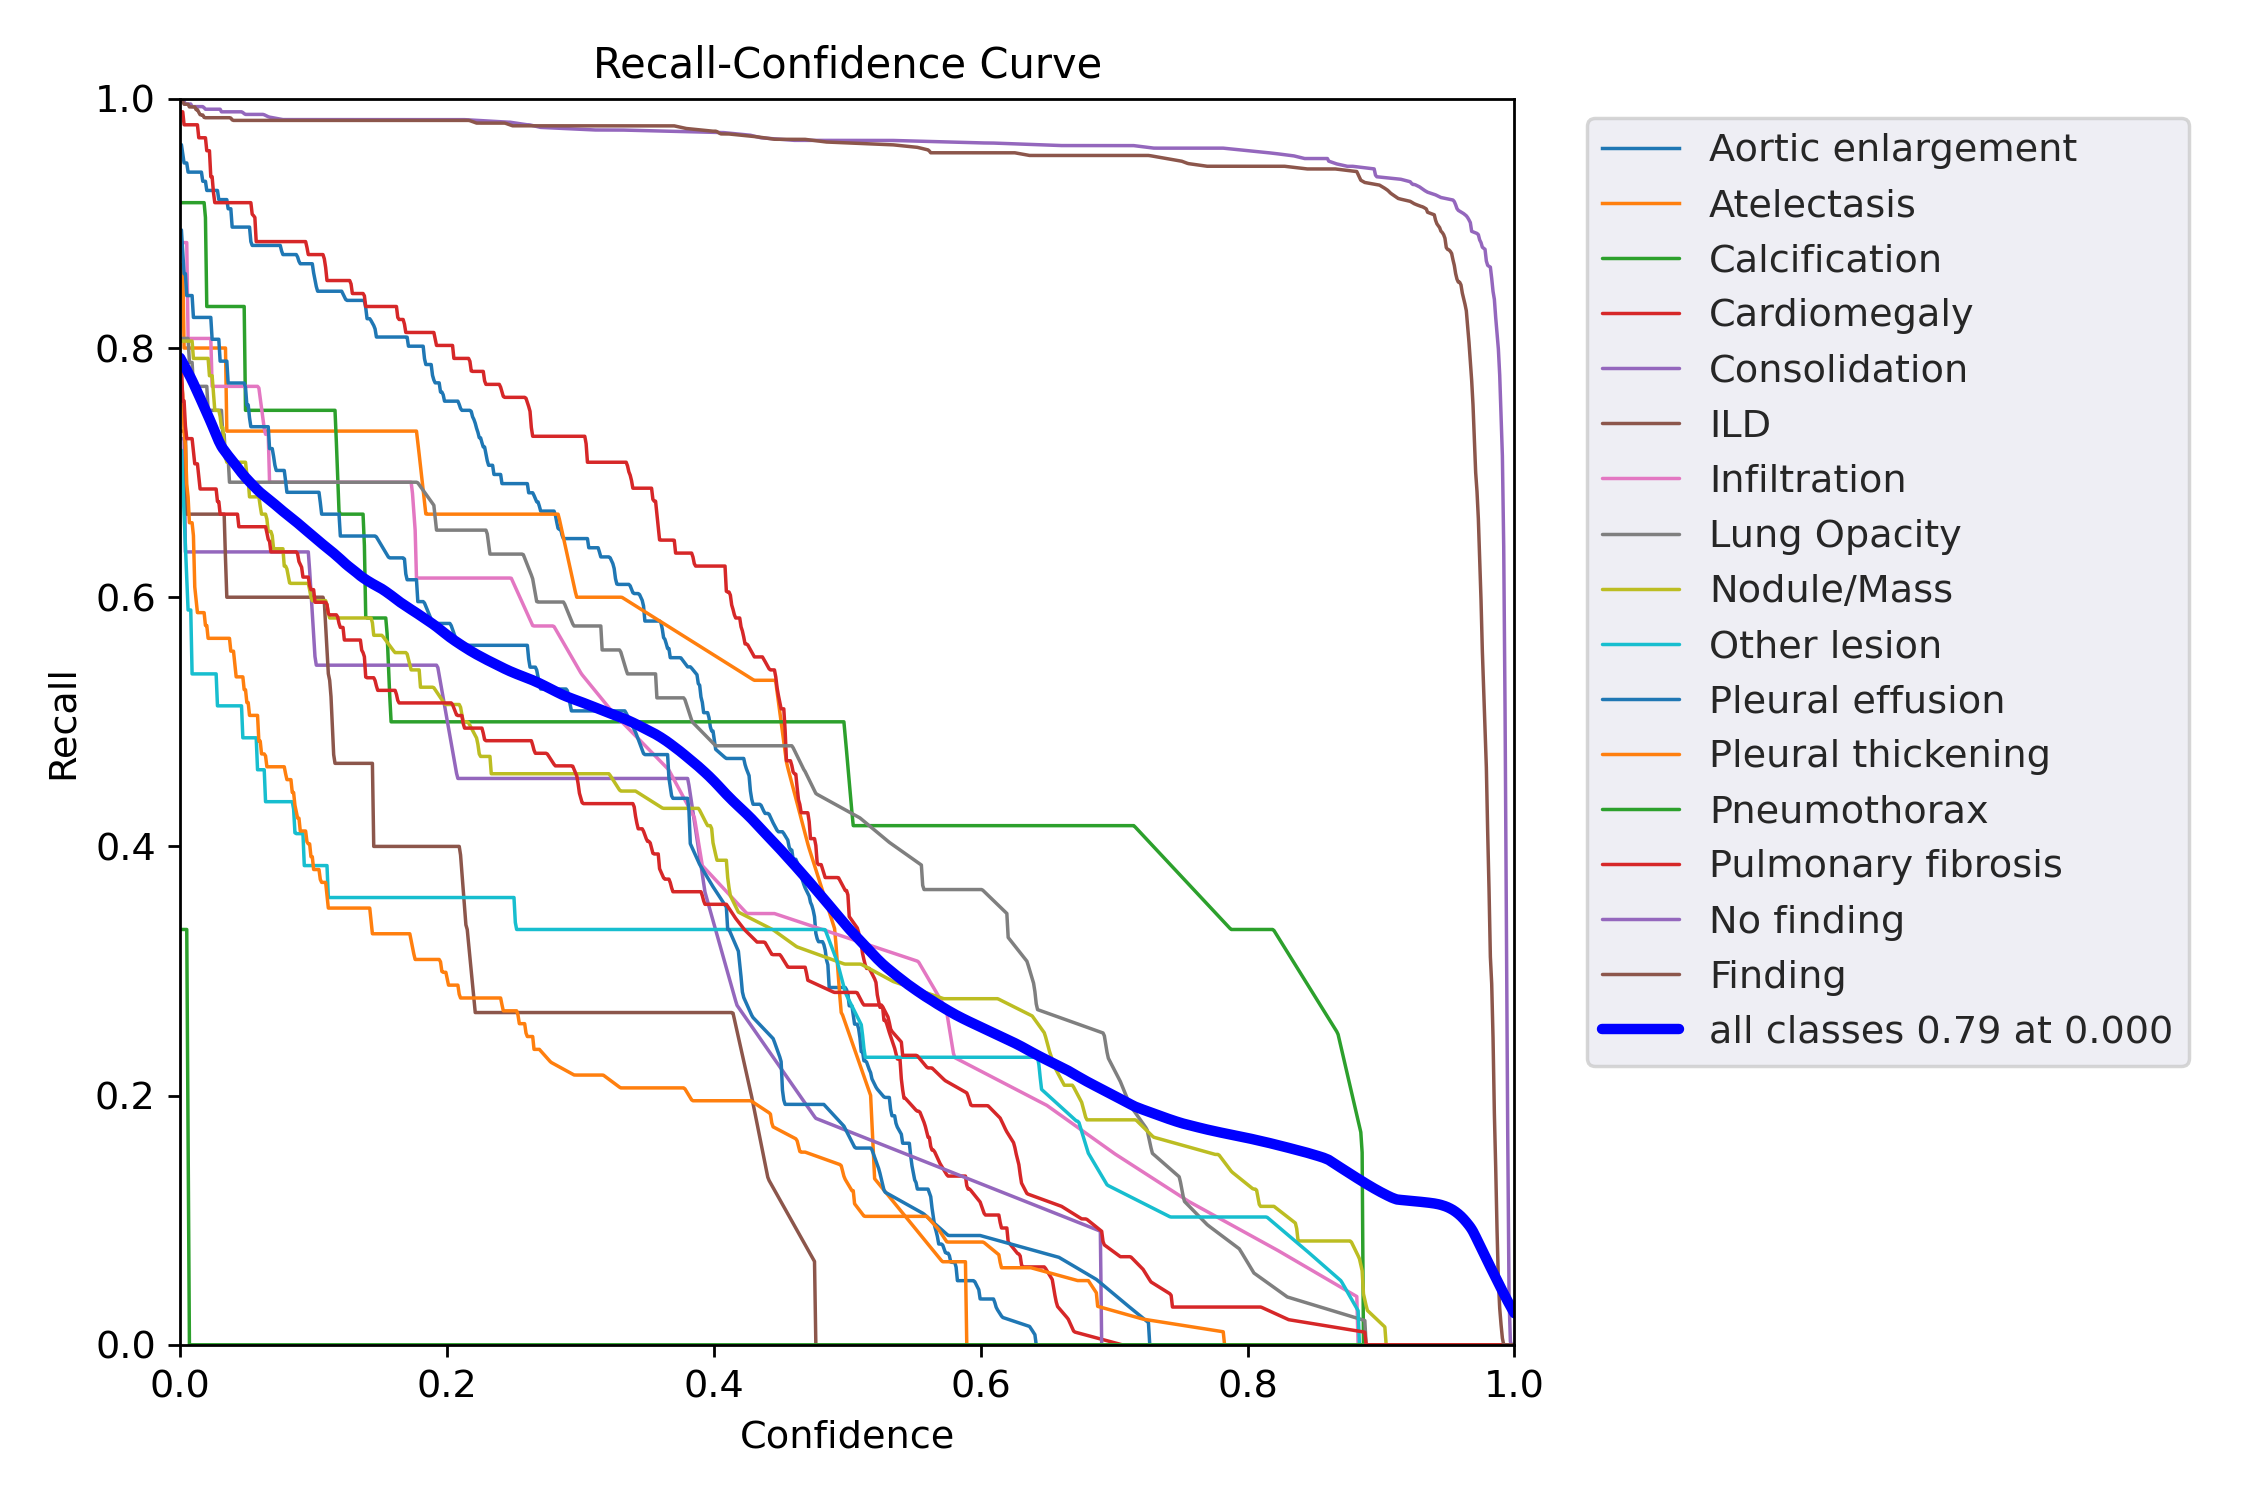

In [ ]:
Image('/content/yolov5/runs/train/exp/R_curve.png', width=800) # Display R Curve

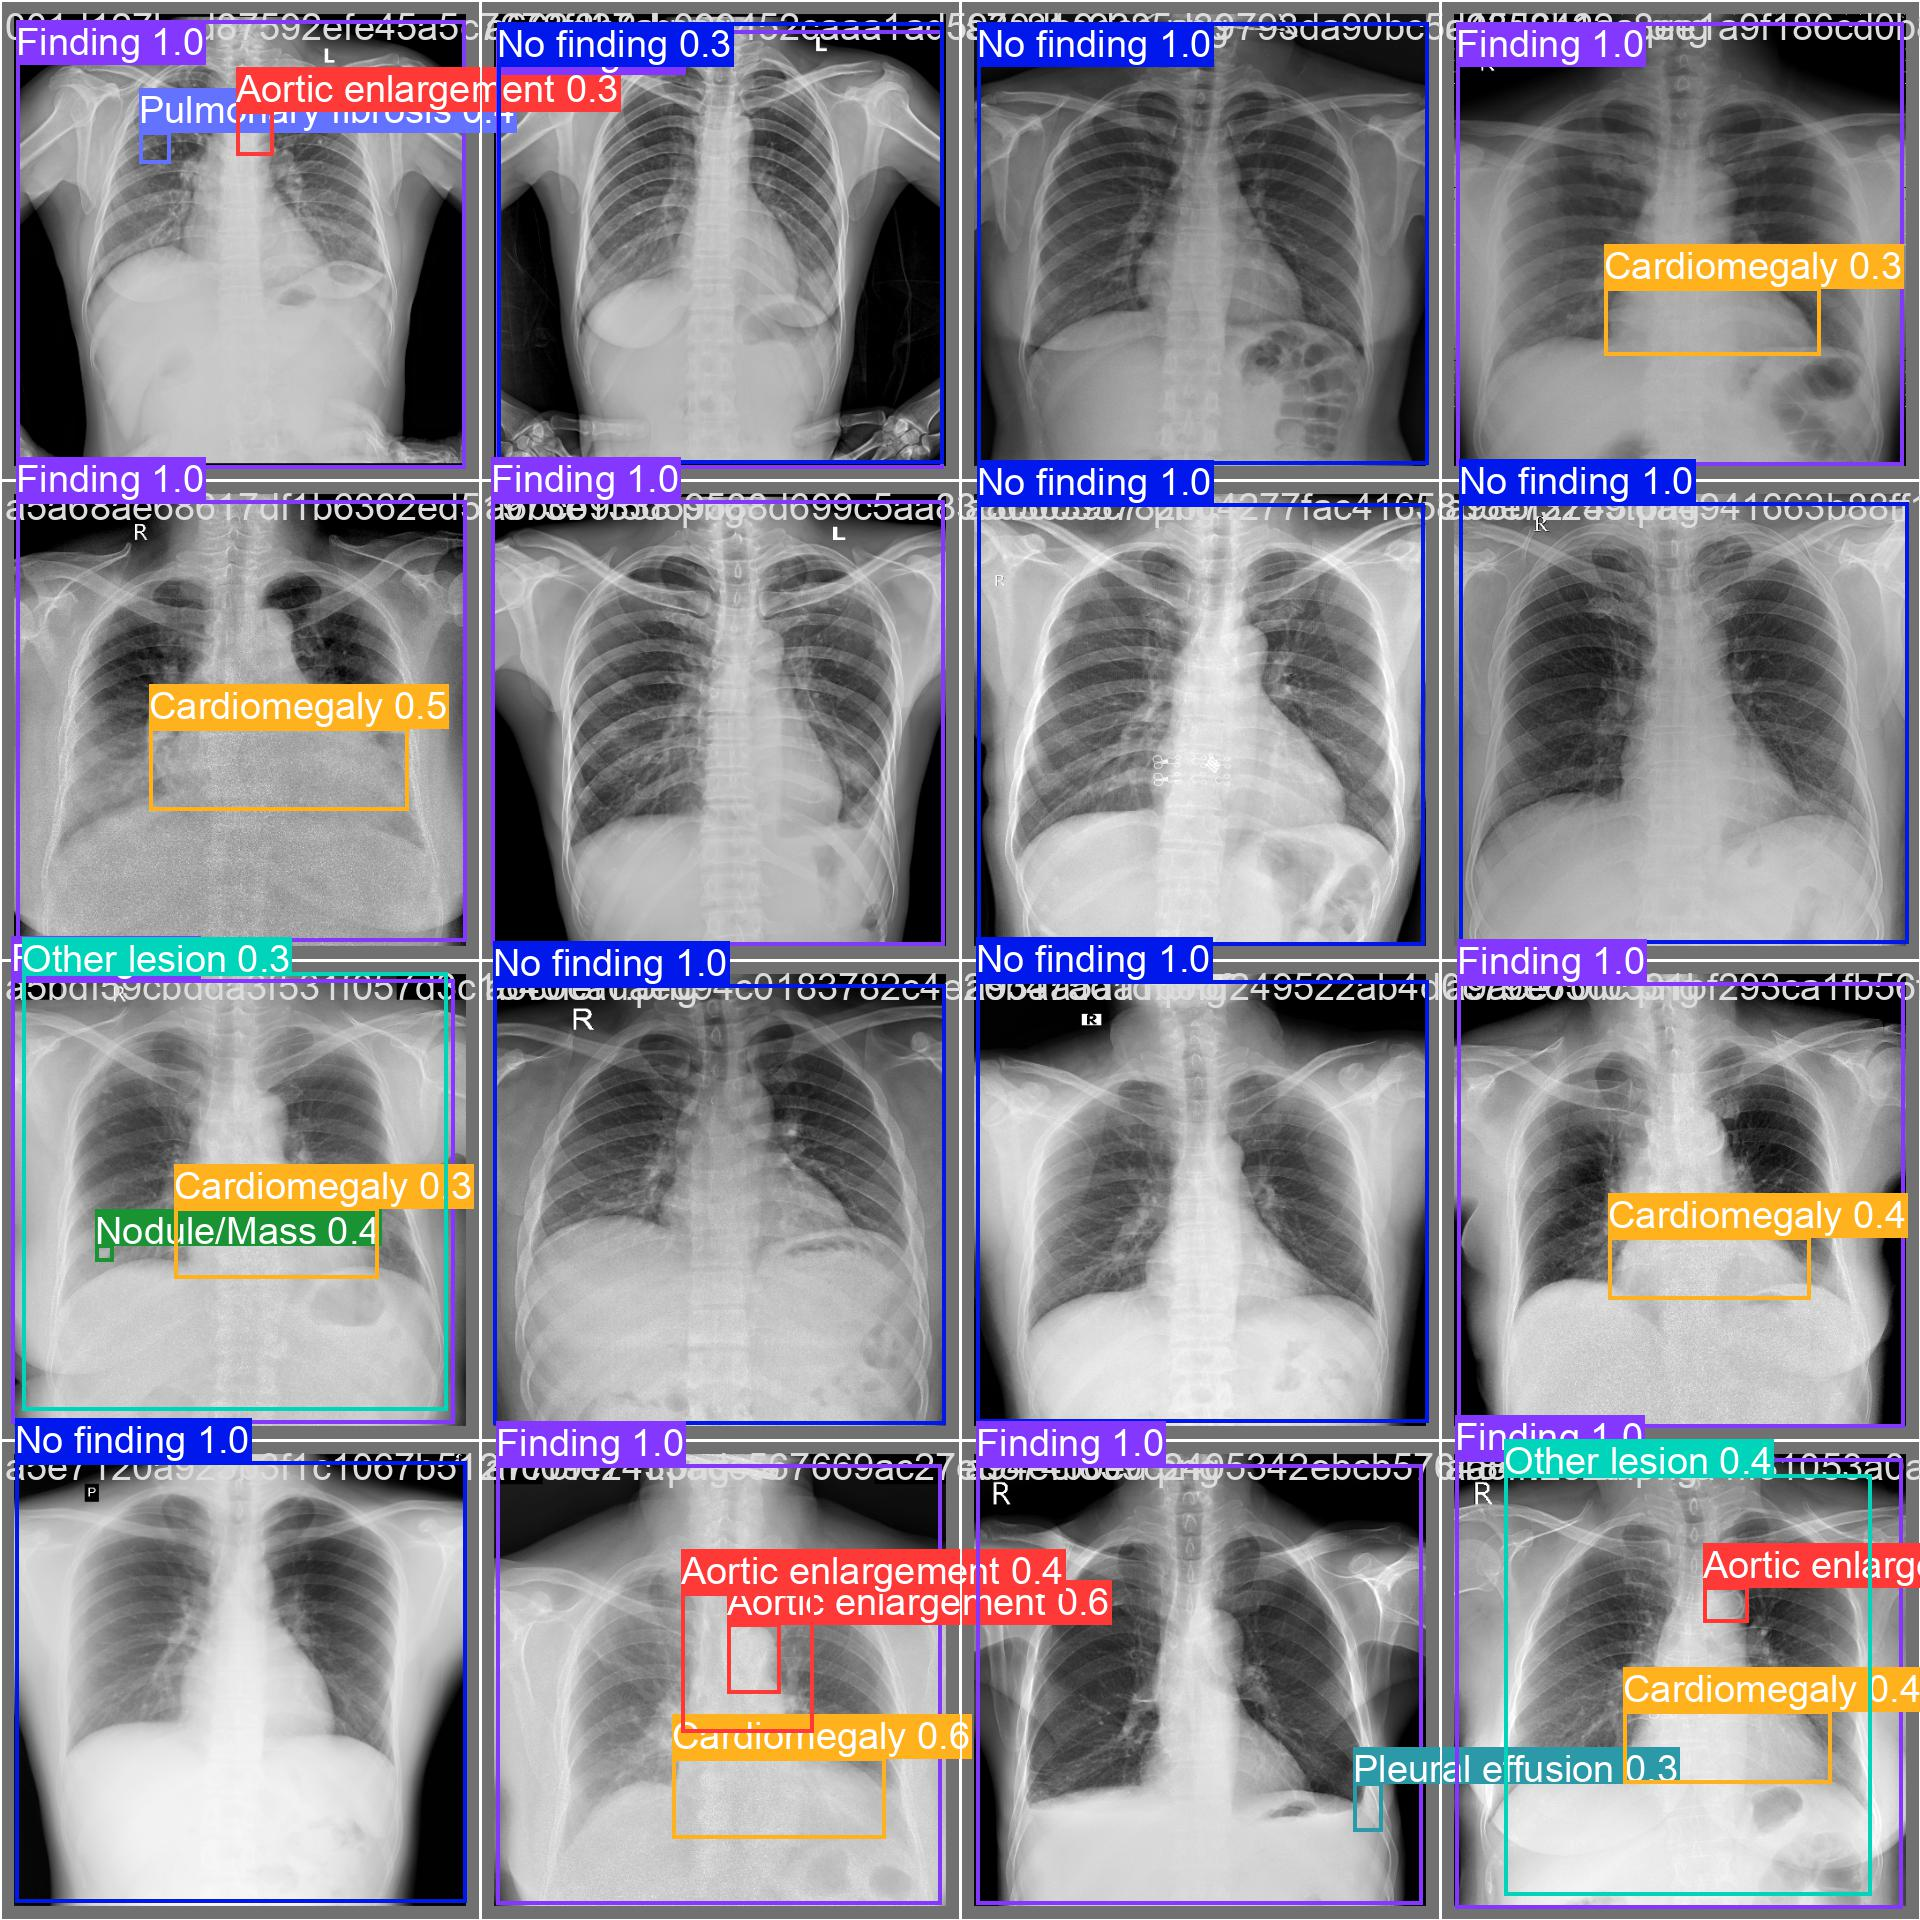

In [ ]:
Image('/content/yolov5/runs/train/exp/val_batch0_pred.jpg', width=800) # Displays Prediction Results (Batch 0)

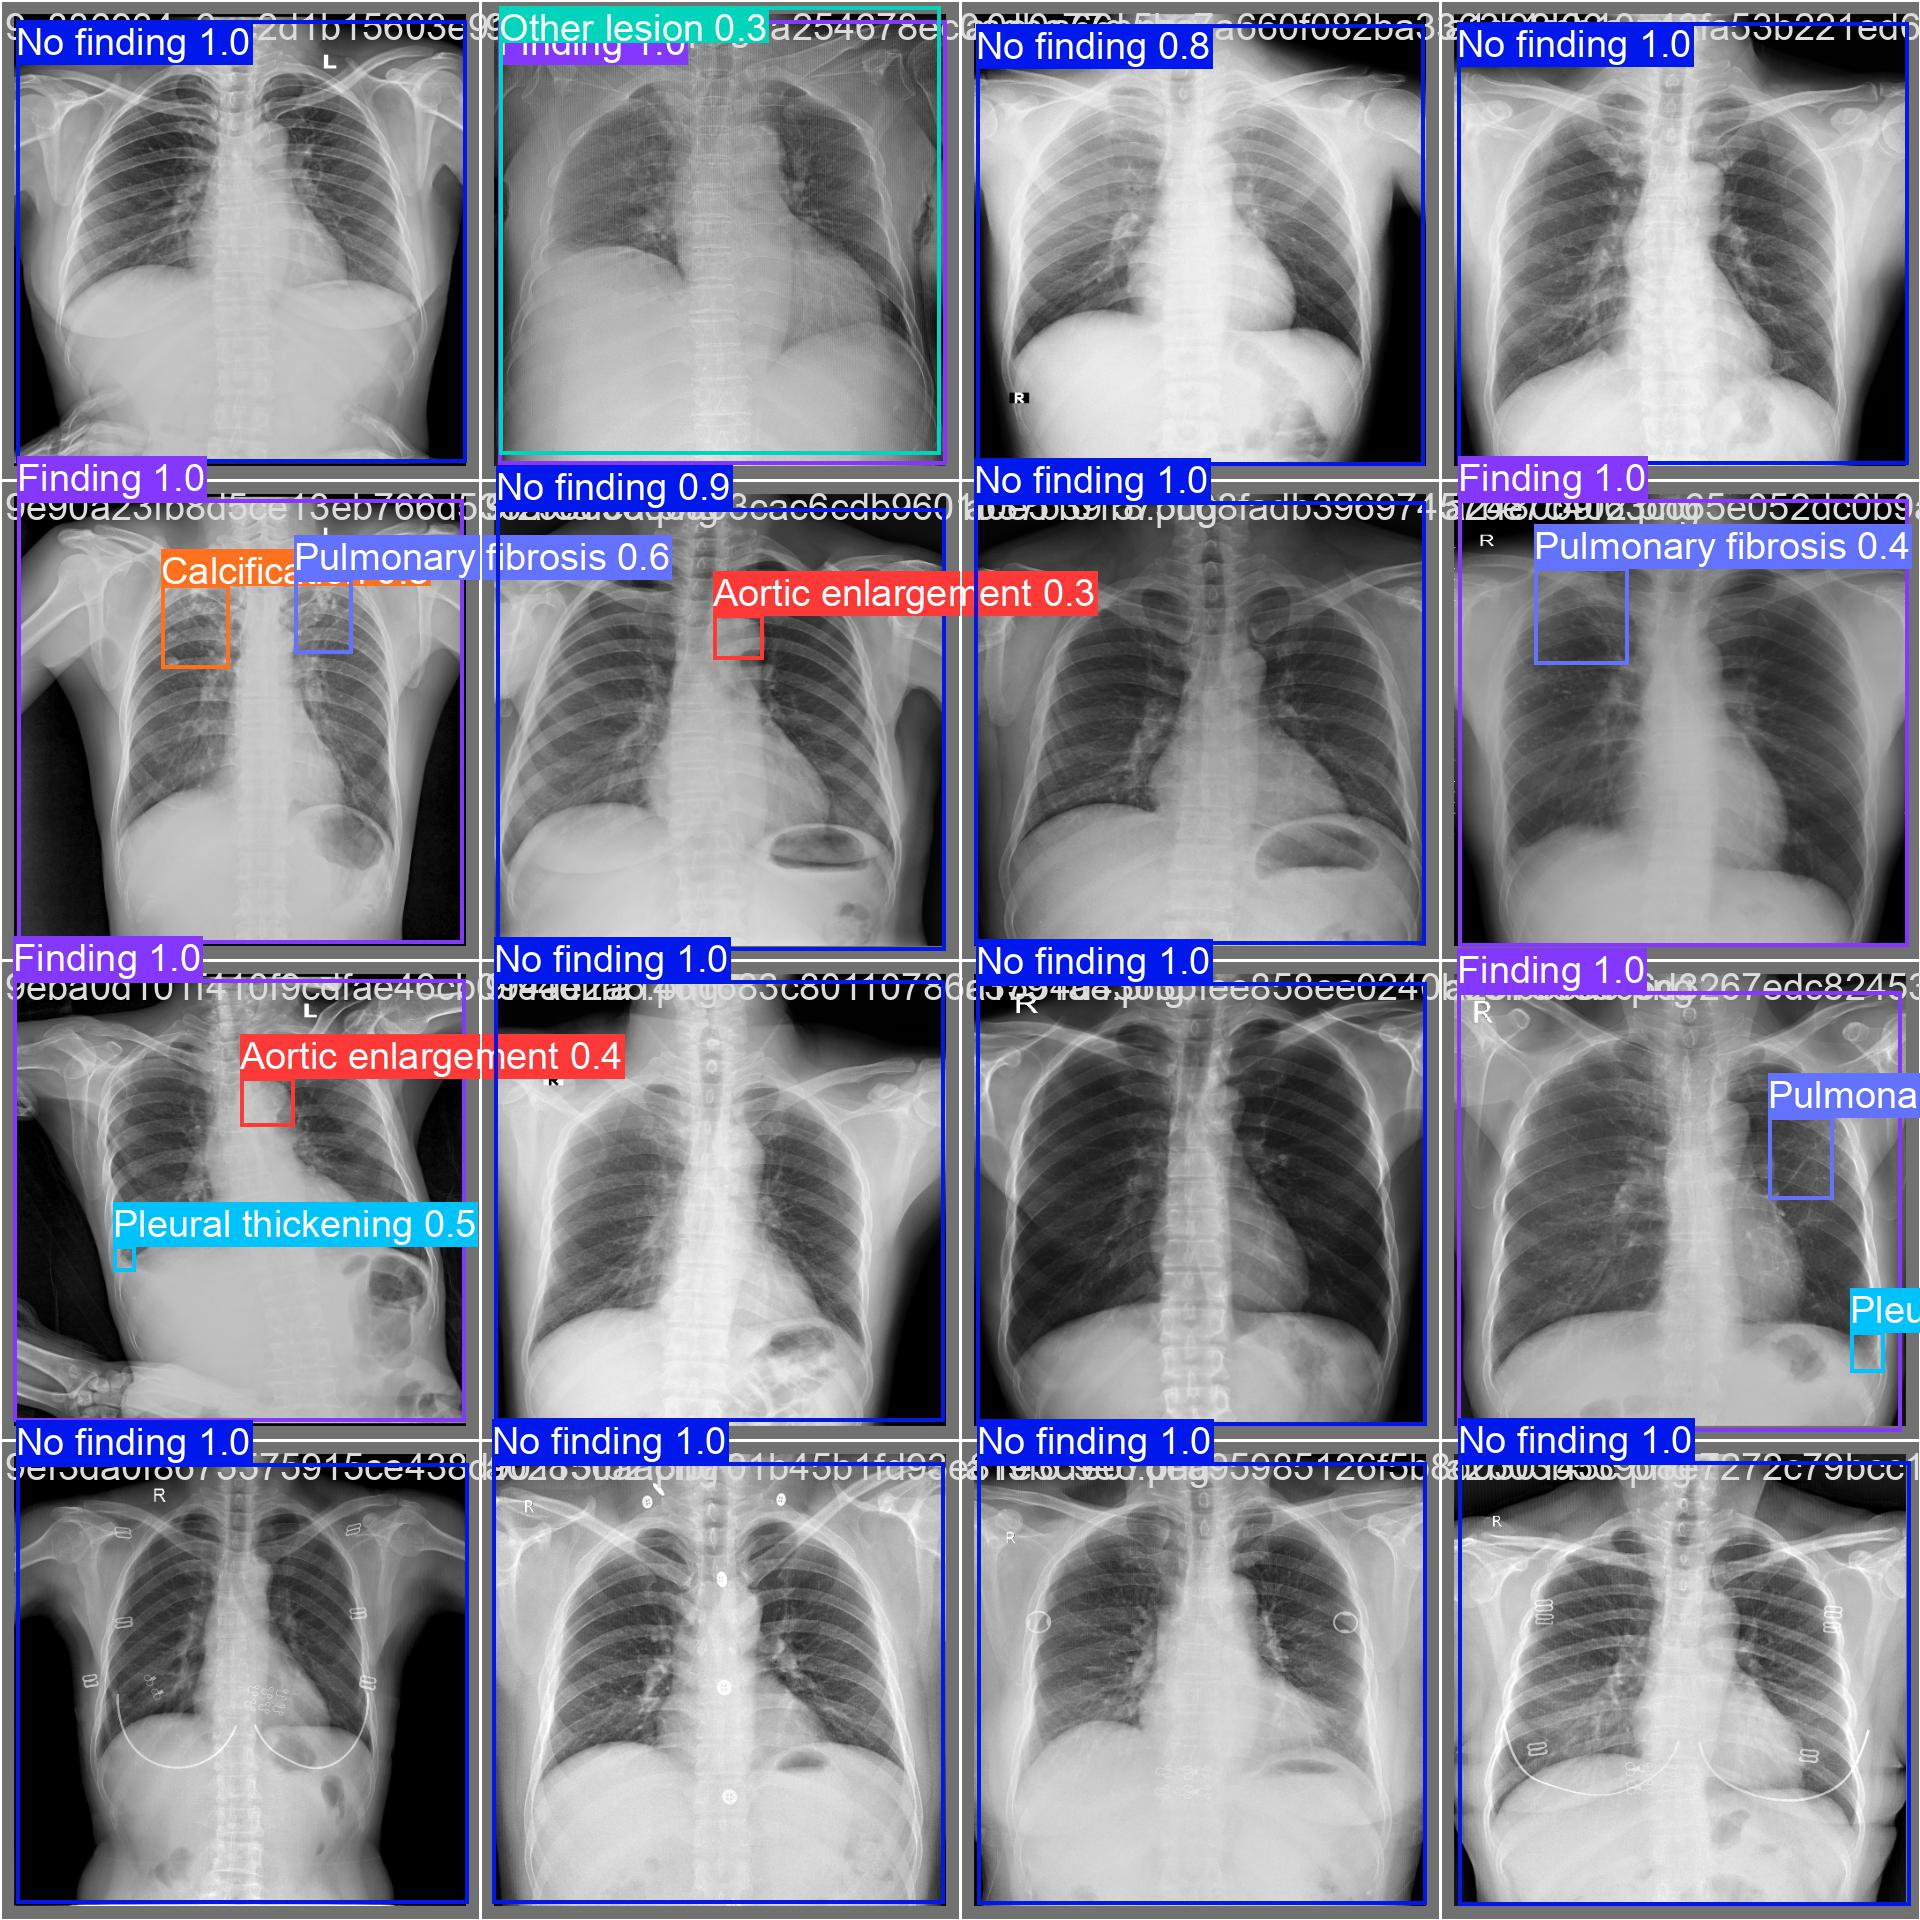

In [ ]:
Image('/content/yolov5/runs/train/exp/val_batch1_pred.jpg', width=800) # Displays Prediction Results (Batch 1)

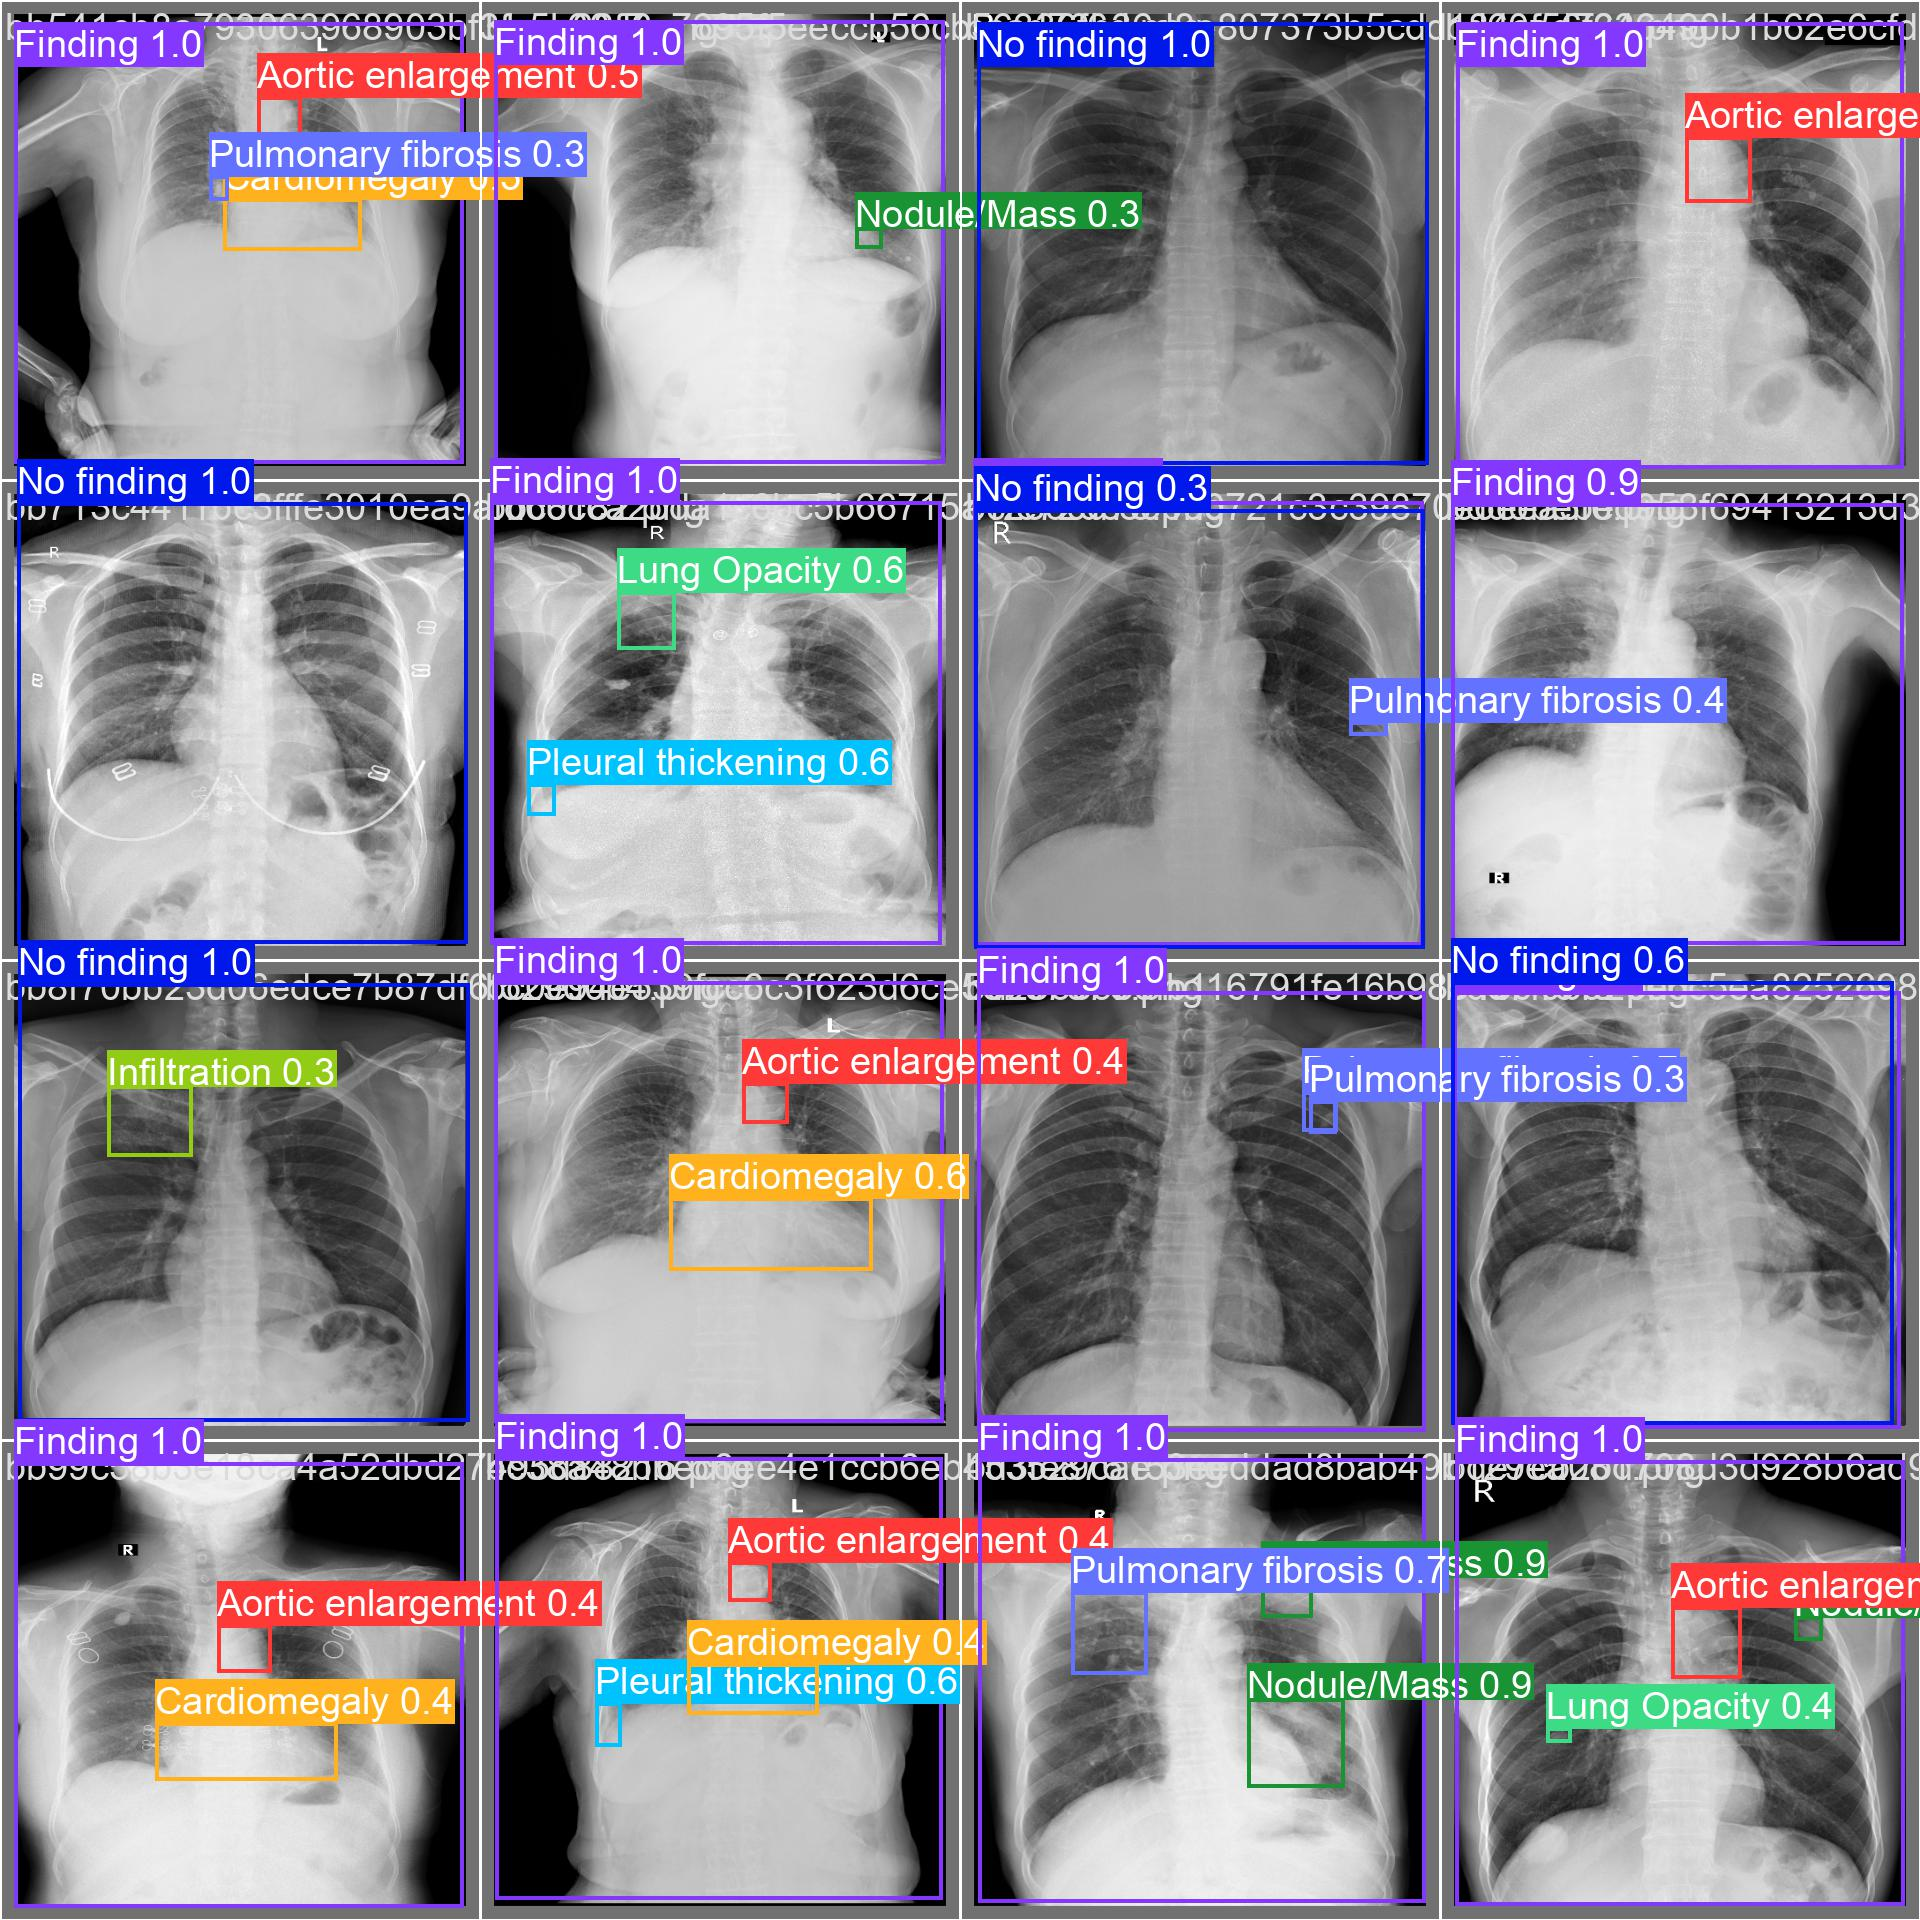

In [ ]:
Image('/content/yolov5/runs/train/exp/val_batch2_pred.jpg', width=800) # Displays Prediction Results (Batch 2)

Create submission.csv file to submit the results to the Kaggle Competition

In [ ]:
# Path of the labels directory
labels_dir = "/content/yolov5/runs/detect/exp/labels/"

dfs = [] # Empty list to store the dataframes

for filename in os.listdir(labels_dir):
    if filename.endswith(".txt"):
        data = pd.read_csv(os.path.join(labels_dir, filename), delimiter=' ', header=None)
        
        # concatenate the columns into a single string
        data['Prediction String'] = data.apply(lambda x: ' '.join(x.astype(str)), axis=1)
        
        # drop the original columns
        data = data.drop(columns=[0,1,2,3,4,5])
        
        # extract the image_id from the filename
        image_id = os.path.splitext(filename)[0]
        
        # add a column with the same value
        data.insert(0, 'image_id', image_id)
        
        # append the dataframe to the list
        dfs.append(data)

# concatenate all the dataframes into a single dataframe
result = pd.concat(dfs)

# save the dataframe to a CSV file
result.to_csv('submission.csv', index=False)

# print the resulting dataframe
print(result)

                            image_id  \
0   1c8036c48a361f409364bf1fe5a43b42   
0   36cf5300d146ed2c232acd54b45f317e   
0   7d610aae49bf4f979e16c2d8859f5f87   
0   68b817bf3890866ba918e6e8af133807   
0   6f5f85902e1a68488dd8b227d8ded75f   
..                               ...   
0   2d4a3f928bbd1cf6cec20fc617af2fa3   
0   23c8f8eb87760b68c710f0bf5ebbbc2b   
0   2cdd80120a508ec319a0f623d5f65bb3   
0   6f8e0af5fff2c4c45f6eb841a4221235   
1   6f8e0af5fff2c4c45f6eb841a4221235   

                                    Prediction String  
0              14.0 0.499023 0.5 0.998047 1.0 0.99477  
0             15.0 0.493164 0.5 0.986328 1.0 0.832723  
0                       15.0 0.5 0.5 1.0 1.0 0.979927  
0             14.0 0.500977 0.5 0.998047 1.0 0.985357  
0             14.0 0.499023 0.5 0.998047 1.0 0.992647  
..                                                ...  
0        15.0 0.5 0.501953 0.996094 0.996094 0.985931  
0             14.0 0.500977 0.5 0.998047 1.0 0.977575  
0             1

Submission to the Kaggle Competition

In [ ]:
!kaggle competitions submit -c vinbigdata-chest-xray-abnormalities-detection -f submission.csv -m "Image Resolution: 512X512"

100% 106k/106k [00:00<00:00, 540kB/s]
Successfully submitted to VinBigData Chest X-ray Abnormalities Detection

Validation of the results

In [ ]:
# read the CSV file
df = pd.read_csv('/content/yolov5/submission.csv')

# split the values in the "Prediction String" column into separate columns
df[['class_id', 'conf', 'x_min', 'y_min', 'x_max', 'y_max']] = df['Prediction String'].str.split(' ', expand=True)

# drop the original "Prediction String" column
df.drop('Prediction String', axis=1, inplace=True)

# write the new DataFrame to a CSV file
df.to_csv('validation.csv', index=False)

# Read in the first CSV file
df1 = pd.read_csv('/content/vinbigdata/new_train.csv')

# Read in the second CSV file
df2 = pd.read_csv('validation.csv')

# Merge the two dataframes on the image_id column
merged_df = pd.merge(df1, df2, on='image_id', suffixes=('_1', '_2'))

# Compare the values of the class_id column
comparison = merged_df['class_id_1'] == merged_df['class_id_2']

# Print the comparison results
print(comparison)

# Count the number of true and false values in the comparison series
value_counts = comparison.value_counts()

# Print the value counts
print(value_counts)

# Count the number of true values in the comparison series
num_true = (comparison == True).sum()

# Print the number of true values
print(num_true)

0        True
1       False
2        True
3        True
4        True
        ...  
2112    False
2113     True
2114    False
2115    False
2116     True
Length: 2117, dtype: bool
False    1252
True      865
dtype: int64
865
